In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pingouin as pg
import missingno as msno
from semopy import Model, calc_stats , semplot
from graphviz import Digraph




# Initial Data Preparation

Columns in the dataset:
['EXP_RAT_NUM', 'EXP', 'PSS', 'olderimale', 'olderi', 'Juvenailemale', 'Juvenaile', 'femaleolderi', 'femaleJuvenaile', 'femaleyoung', 'inactive', 'HFD', 'FD', 'LEW', 'EBR', 'MBR', 'PBR', 'ANX_i', 'STR', 'FREAZING', 'female', 'active']

Sample of Raw Data:
   EXP_RAT_NUM                          EXP  PSS  olderimale  olderi  \
0            1  PSS - male -Young - 3 Month    1           0       0   
1            2  PSS - male -Young - 3 Month    1           0       0   
2            3  PSS - male -Young - 3 Month    1           0       0   
3            4  PSS - male -Young - 3 Month    1           0       0   
4            5  PSS - male -Young - 3 Month    1           0       0   

   Juvenailemale  Juvenaile  femaleolderi  femaleJuvenaile  femaleyoung  ...  \
0              0          0             0                0            0  ...   
1              0          0             0                0            0  ...   
2              0          0             0      

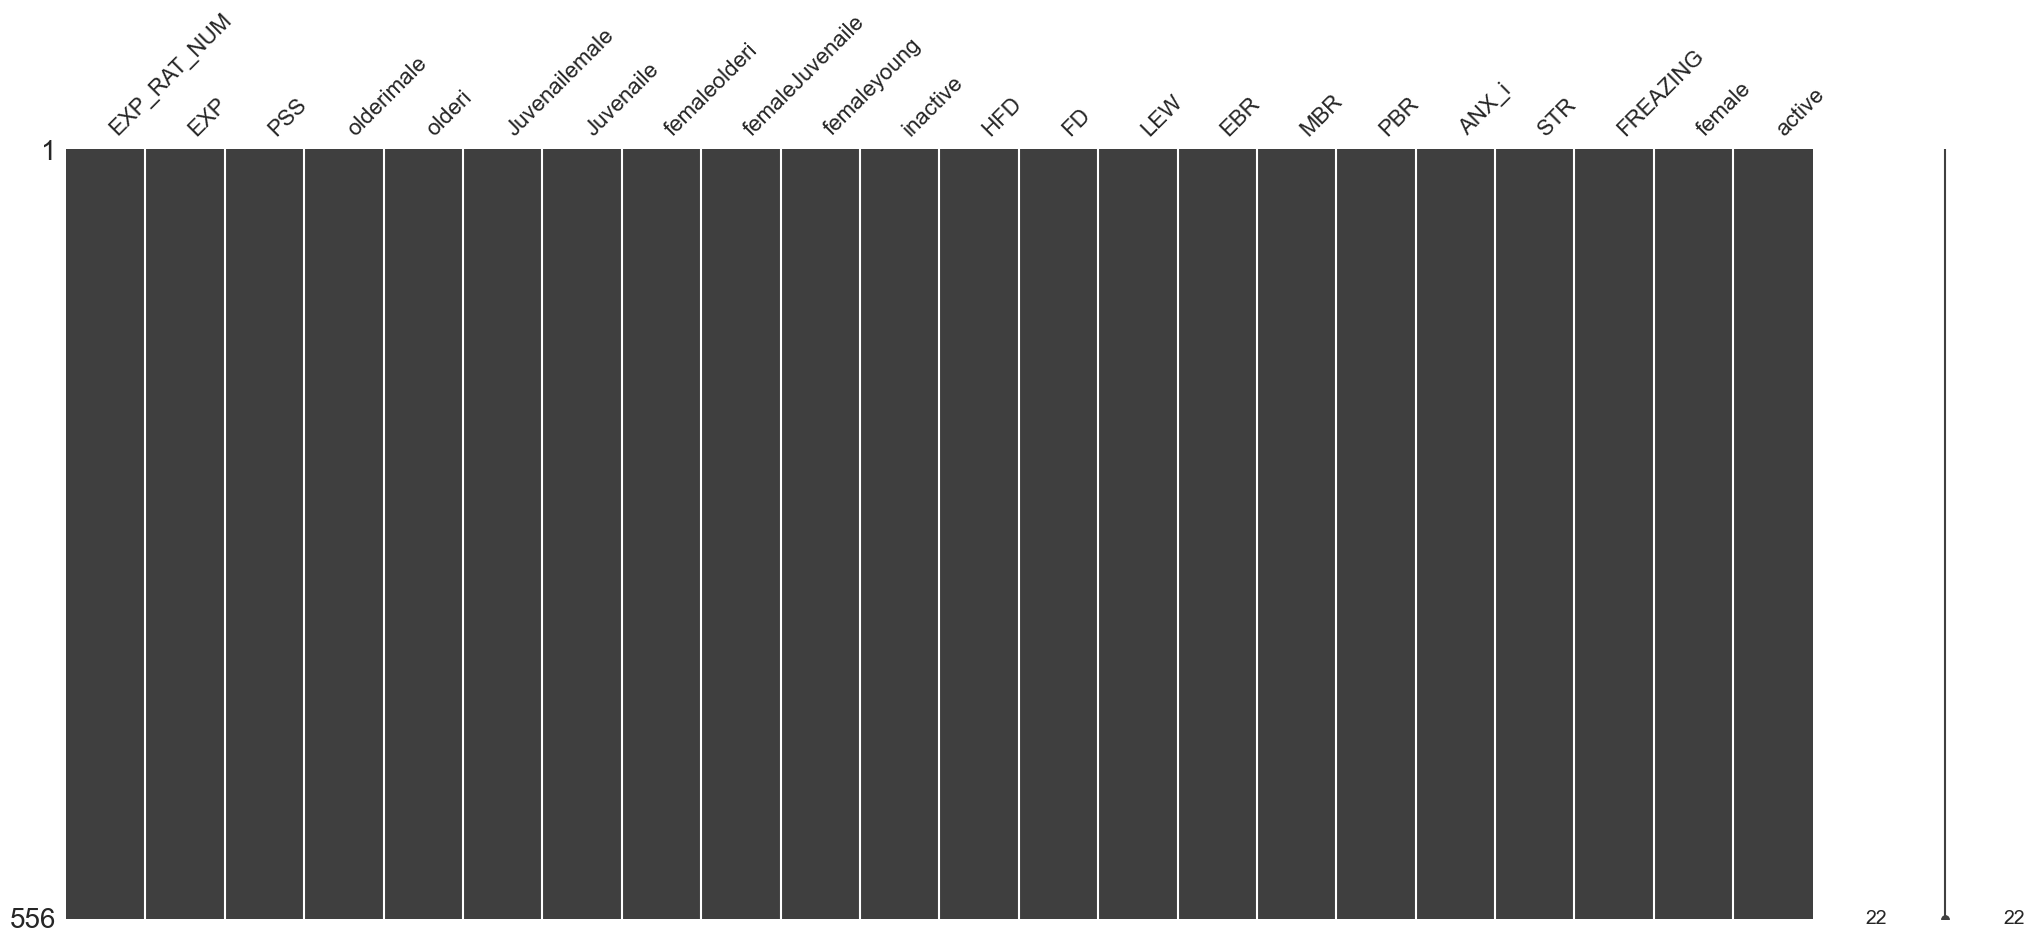

In [5]:

# 1. Load the dataset
df = pd.read_csv('/Users/djourno/PyCharm/SEM_PSS/data.csv')

# 2. Show basic info
print("Columns in the dataset:")
print(df.columns.tolist())
print("\nSample of Raw Data:")
print(df.head())

# 3. Check for constant columns and NaN
constant_columns = df.loc[:, df.nunique() <= 1].columns.tolist()
nan_columns = df.columns[df.isna().any()].tolist()
print("\nConstant columns:", constant_columns)
print("Columns with NaN values:", nan_columns)

# 4. תיאור בסיסי ובדיקת חוסרים
print("\nDescriptive statistics:")
print(df.describe(include='all'))
msno.matrix(df)
plt.show()

# 5. מרכוז ונרמול משתנים
scaler = MinMaxScaler()

# STR
df['STR_norm'] = scaler.fit_transform(df[['STR']])
df['STR_c'] = df['STR_norm'] - df['STR_norm'].mean()

# FREAZING
df['FREAZING_norm'] = scaler.fit_transform(df[['FREAZING']])
df['FREAZING_c'] = df['FREAZING_norm'] - df['FREAZING_norm'].mean()

# ANX_i
df['ANX_i_c'] = df['ANX_i'] - df['ANX_i'].mean()

In [6]:

# פונקציה לניקוי הדאטה (שומרת על פיצ'רים חשובים אם צריך)
def clean_data_for_regression(df, correlation_threshold=0.95, protected_columns=None):
    if protected_columns is None:
        protected_columns = []

    # Drop constant columns
    constant_cols = df.loc[:, df.nunique() <= 1].columns.tolist()
    df = df.drop(columns=constant_cols)
    print(f"Dropped constant columns: {constant_cols}")

    # Drop one of each highly correlated pair, unless protected
    corr_matrix = df.corr(numeric_only=True).abs()
    upper_triangle = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )

    to_drop = []
    for column in upper_triangle.columns:
        if any(upper_triangle[column] > correlation_threshold) and column not in protected_columns:
            to_drop.append(column)

    df = df.drop(columns=to_drop)
    print(f"Dropped highly correlated columns (excluding protected ones): {to_drop}")

    return df

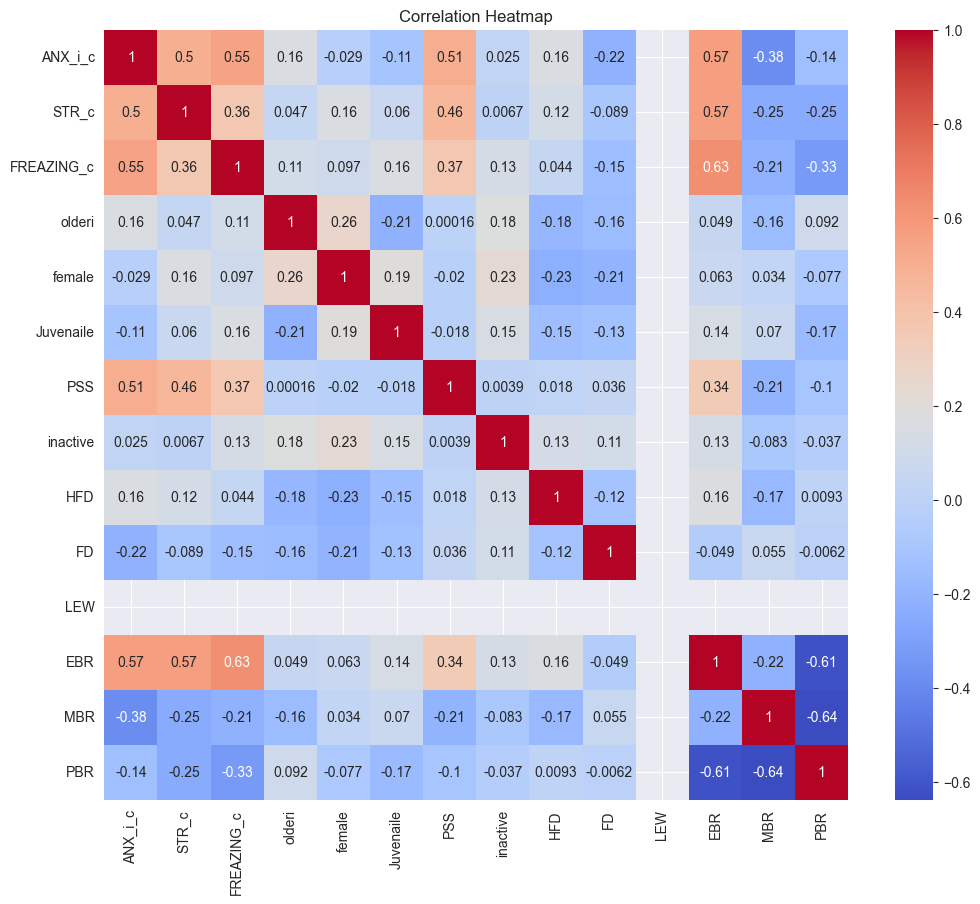

In [7]:

# 6. מטריצת קורלציות (Pearson בין רציפים)
cont_vars = ['ANX_i_c', 'STR_c', 'FREAZING_c']
bin_vars = ['olderi', 'female', 'Juvenaile', 'PSS', 'inactive', 'HFD', 'FD', 'LEW', 'EBR', 'MBR', 'PBR']

# חישוב קורלציות
corr = pg.pairwise_corr(df[cont_vars + bin_vars], method='pearson')

# הצגת מטריצת חום
plt.figure(figsize=(12,10))
sns.heatmap(df[cont_vars + bin_vars].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [8]:

#7. ניקוי דאטה (בלי למחוק פיצ'רים חשובים שיצרנו)
protected = ['STR_norm', 'STR_c', 'FREAZING_norm', 'FREAZING_c', 'ANX_i_c']
df = clean_data_for_regression(df, protected_columns=protected)


Dropped constant columns: ['LEW']
Dropped highly correlated columns (excluding protected ones): ['active']


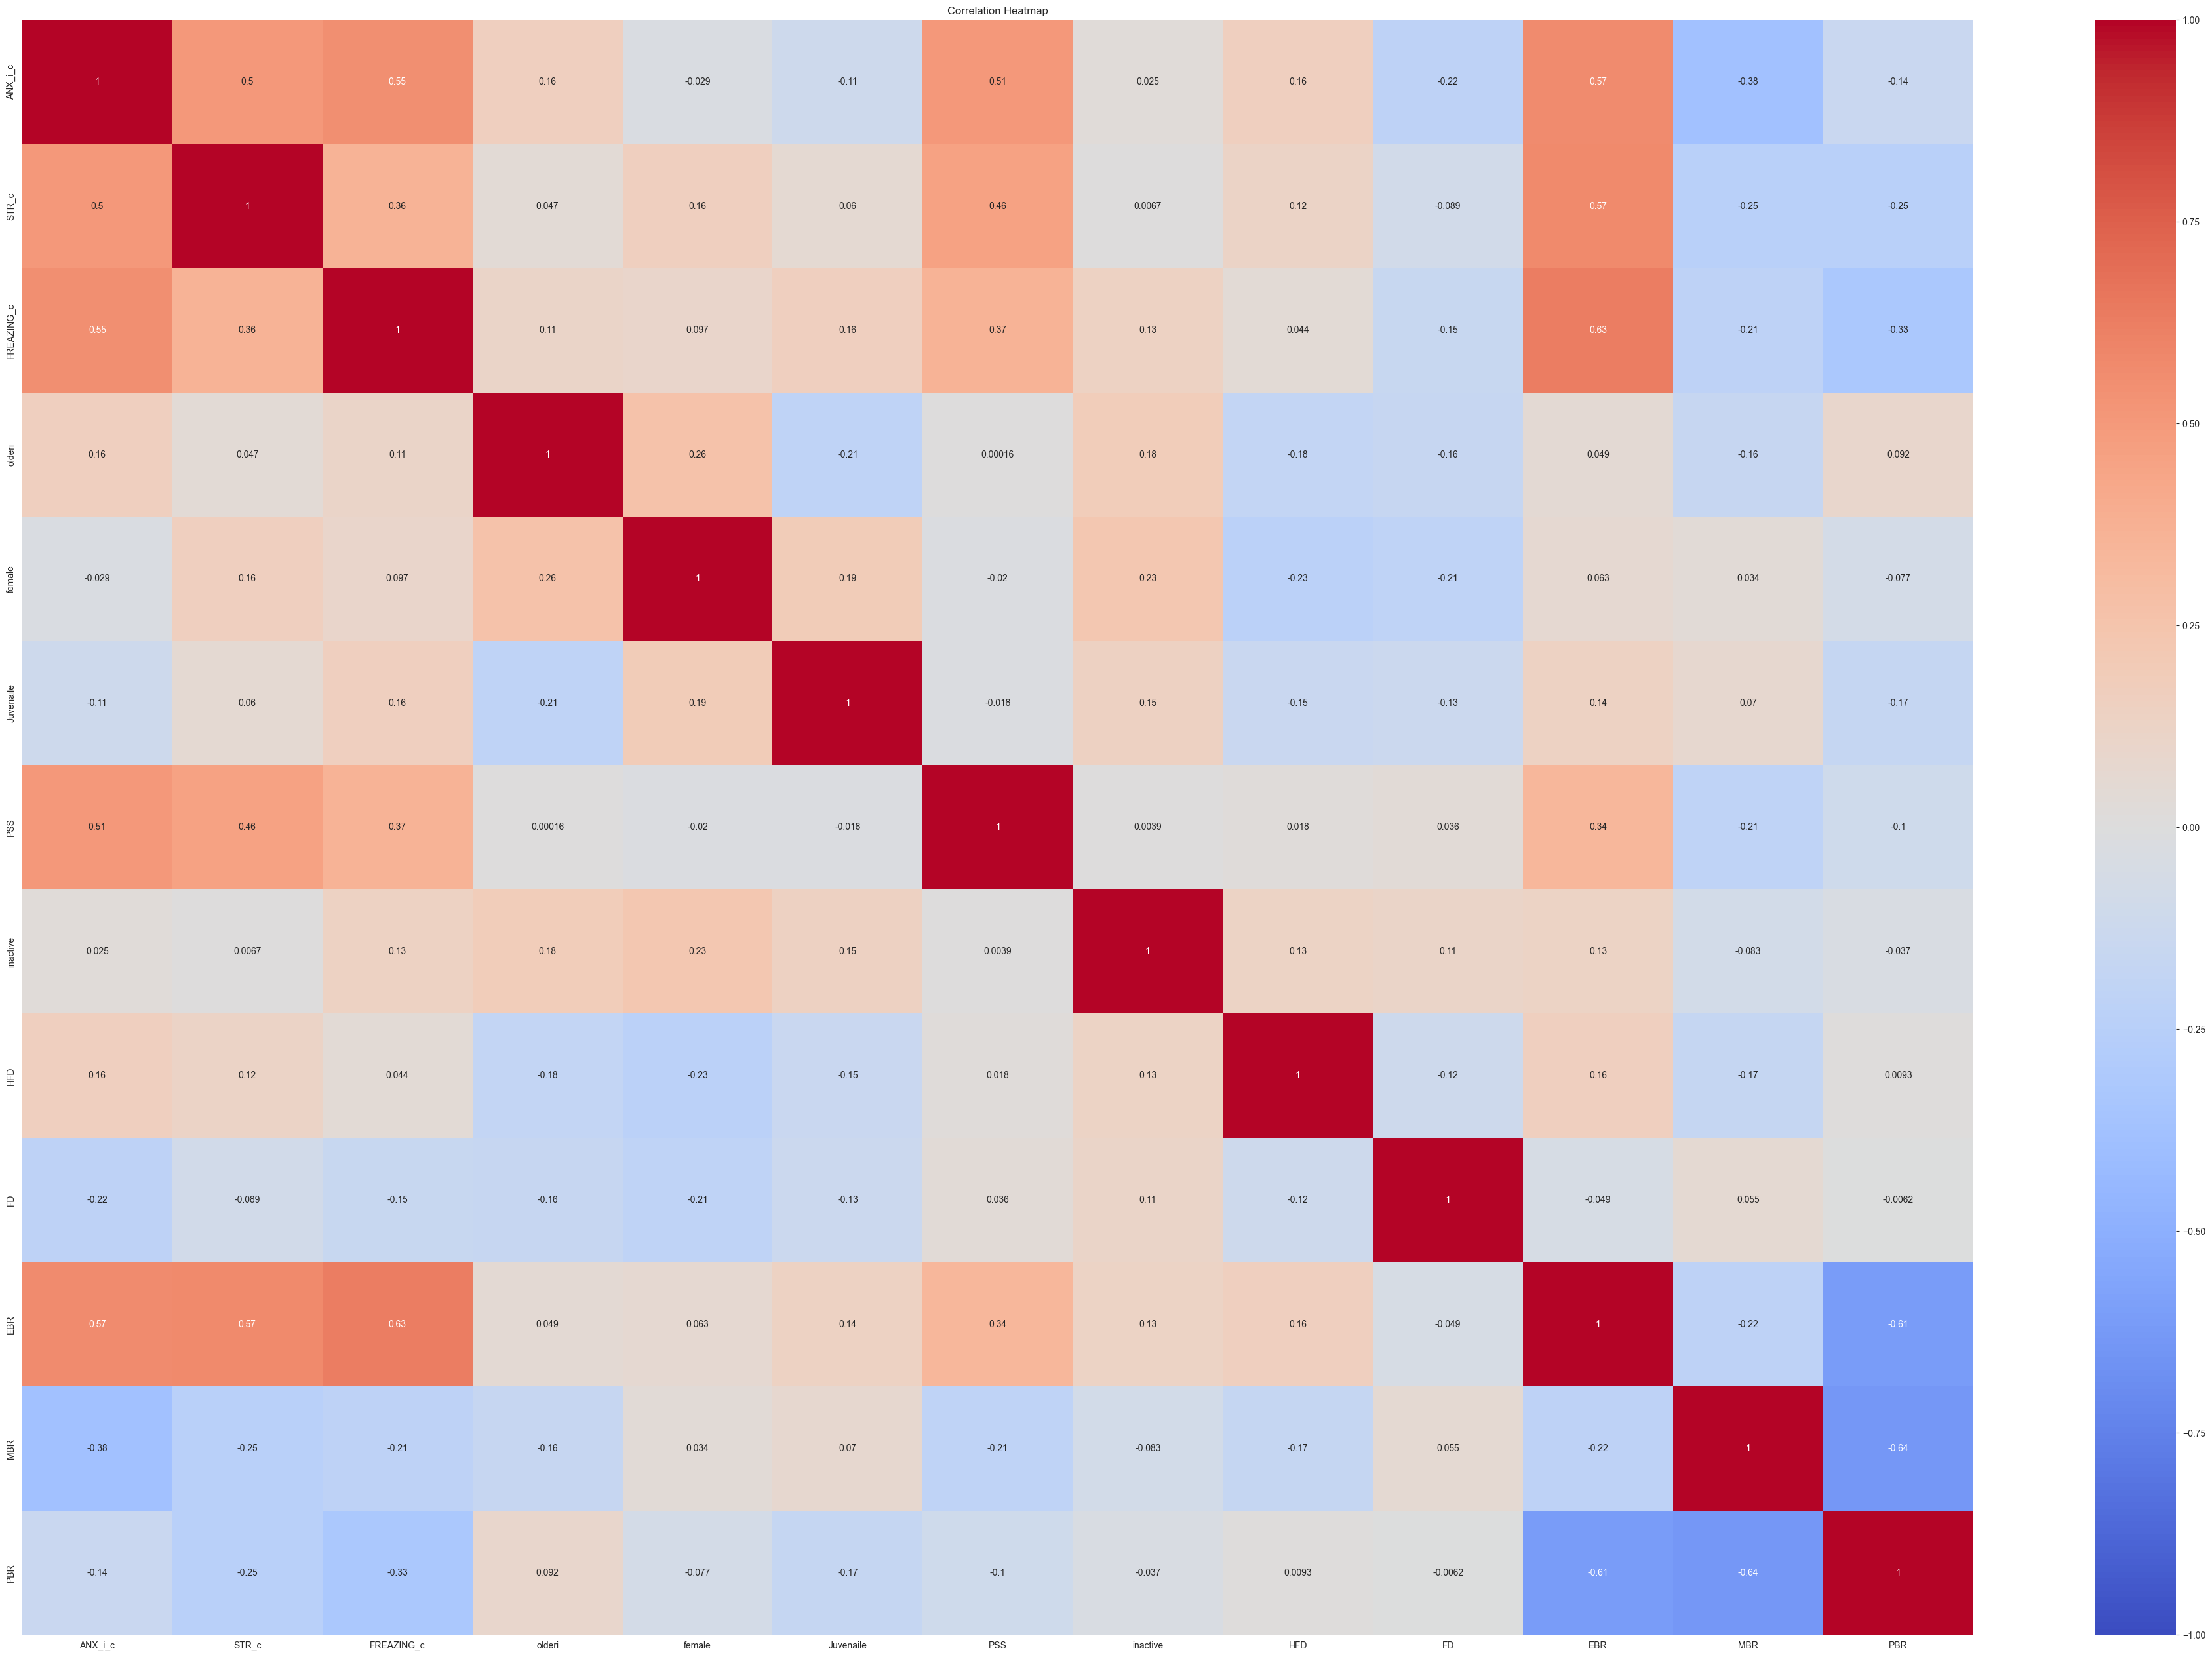


Detailed Correlation Matrix:
          X           Y   method alternative    n         r           CI95%  \
0   ANX_i_c       STR_c  pearson   two-sided  556  0.500290    [0.44, 0.56]   
1   ANX_i_c  FREAZING_c  pearson   two-sided  556  0.548358     [0.49, 0.6]   
2   ANX_i_c      olderi  pearson   two-sided  556  0.159987    [0.08, 0.24]   
3   ANX_i_c      female  pearson   two-sided  556 -0.028519   [-0.11, 0.05]   
4   ANX_i_c   Juvenaile  pearson   two-sided  556 -0.110774  [-0.19, -0.03]   
..      ...         ...      ...         ...  ...       ...             ...   
73       FD         MBR  pearson   two-sided  556  0.055228   [-0.03, 0.14]   
74       FD         PBR  pearson   two-sided  556 -0.006218   [-0.09, 0.08]   
75      EBR         MBR  pearson   two-sided  556 -0.216535  [-0.29, -0.14]   
76      EBR         PBR  pearson   two-sided  556 -0.614279  [-0.66, -0.56]   
77      MBR         PBR  pearson   two-sided  556 -0.637355  [-0.68, -0.59]   

           p-unc     

In [9]:
# 8. מטריצת קורלציות (שוב)

# משתנים רציפים ומרוכזים
cont_vars = ['ANX_i_c', 'STR_c', 'FREAZING_c']

# משתנים בינאריים
bin_vars = ['olderi', 'female', 'Juvenaile', 'PSS', 'inactive', 'HFD', 'FD', 'EBR', 'MBR', 'PBR']

# שמירת הדאטה המקורי לפני הצמצום
df_old = df.copy()

# יצירת df חדש רק עם המשתנים הרלוונטיים
df = df[cont_vars + bin_vars].copy()

# חישוב מטריצת קורלציות עם pingouin
corr = pg.pairwise_corr(df, method='pearson')

# הצגת מטריצת חום של הקורלציות
plt.figure(figsize=(48, 32))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

# הדפסת מטריצת הקורלציות המפורטת
print("\nDetailed Correlation Matrix:")
print(corr)

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 9. בדיקת VIF
X = df.assign(const=1)  # הוספת קבוע

# חישוב VIF
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# הצגת ה-VIF
print("\nVariance Inflation Factors (VIF):")
print(vif_data)

# חיפוש משתנים בעייתיים
problematic = vif_data[vif_data['VIF'] > 10]
print("\nVariables with VIF > 10:")
print(problematic)


Variance Inflation Factors (VIF):
      Variable       VIF
0      ANX_i_c  2.430867
1        STR_c  1.864943
2   FREAZING_c  1.978049
3       olderi  1.389019
4       female  1.372394
5    Juvenaile  1.372014
6          PSS  1.557481
7     inactive  1.291492
8          HFD  1.368797
9           FD  1.353470
10         EBR       inf
11         MBR       inf
12         PBR       inf
13       const  0.000000

Variables with VIF > 10:
   Variable  VIF
10      EBR  inf
11      MBR  inf
12      PBR  inf


/Users/djourno/PyCharm/SEM_PSS/.venv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/Users/djourno/PyCharm/SEM_PSS/.venv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


In [11]:
df = df.drop(columns=['MBR'])
# חישוב VIF מחדש אחרי הדרופ
X = df.assign(const=1)

vif_data = pd.DataFrame({
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# מסנן החוצה את הקבוע מהתצוגה
vif_data = vif_data[vif_data['Variable'] != 'const']

print("\nNew Variance Inflation Factors (VIF) after dropping 'MBR':")
print(vif_data)


New Variance Inflation Factors (VIF) after dropping 'MBR':
      Variable       VIF
0      ANX_i_c  2.430867
1        STR_c  1.864943
2   FREAZING_c  1.978049
3       olderi  1.389019
4       female  1.372394
5    Juvenaile  1.372014
6          PSS  1.557481
7     inactive  1.291492
8          HFD  1.368797
9           FD  1.353470
10         EBR  3.779097
11         PBR  1.885146


In [12]:

# 1. female × olderi
df['female_x_olderi']    = df['female'] * df['olderi']

# 2. female × Juvenaile
df['female_x_Juvenaile'] = df['female'] * df['Juvenaile']

# חישוב VIF מחדש אחרי הוספה
X = df.assign(const=1)

vif_data = pd.DataFrame({
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# מסנן החוצה את הקבוע מהתצוגה
vif_data = vif_data[vif_data['Variable'] != 'const']

print("\nNew Variance Inflation Factors (VIF):")
print(vif_data)


New Variance Inflation Factors (VIF):
              Variable       VIF
0              ANX_i_c  2.470307
1                STR_c  2.002074
2           FREAZING_c  2.008851
3               olderi  2.548432
4               female  2.926226
5            Juvenaile  2.406482
6                  PSS  1.603151
7             inactive  1.365965
8                  HFD  1.420640
9                   FD  1.445674
10                 EBR  3.798351
11                 PBR  1.925510
12     female_x_olderi  3.558756
13  female_x_Juvenaile  2.913910


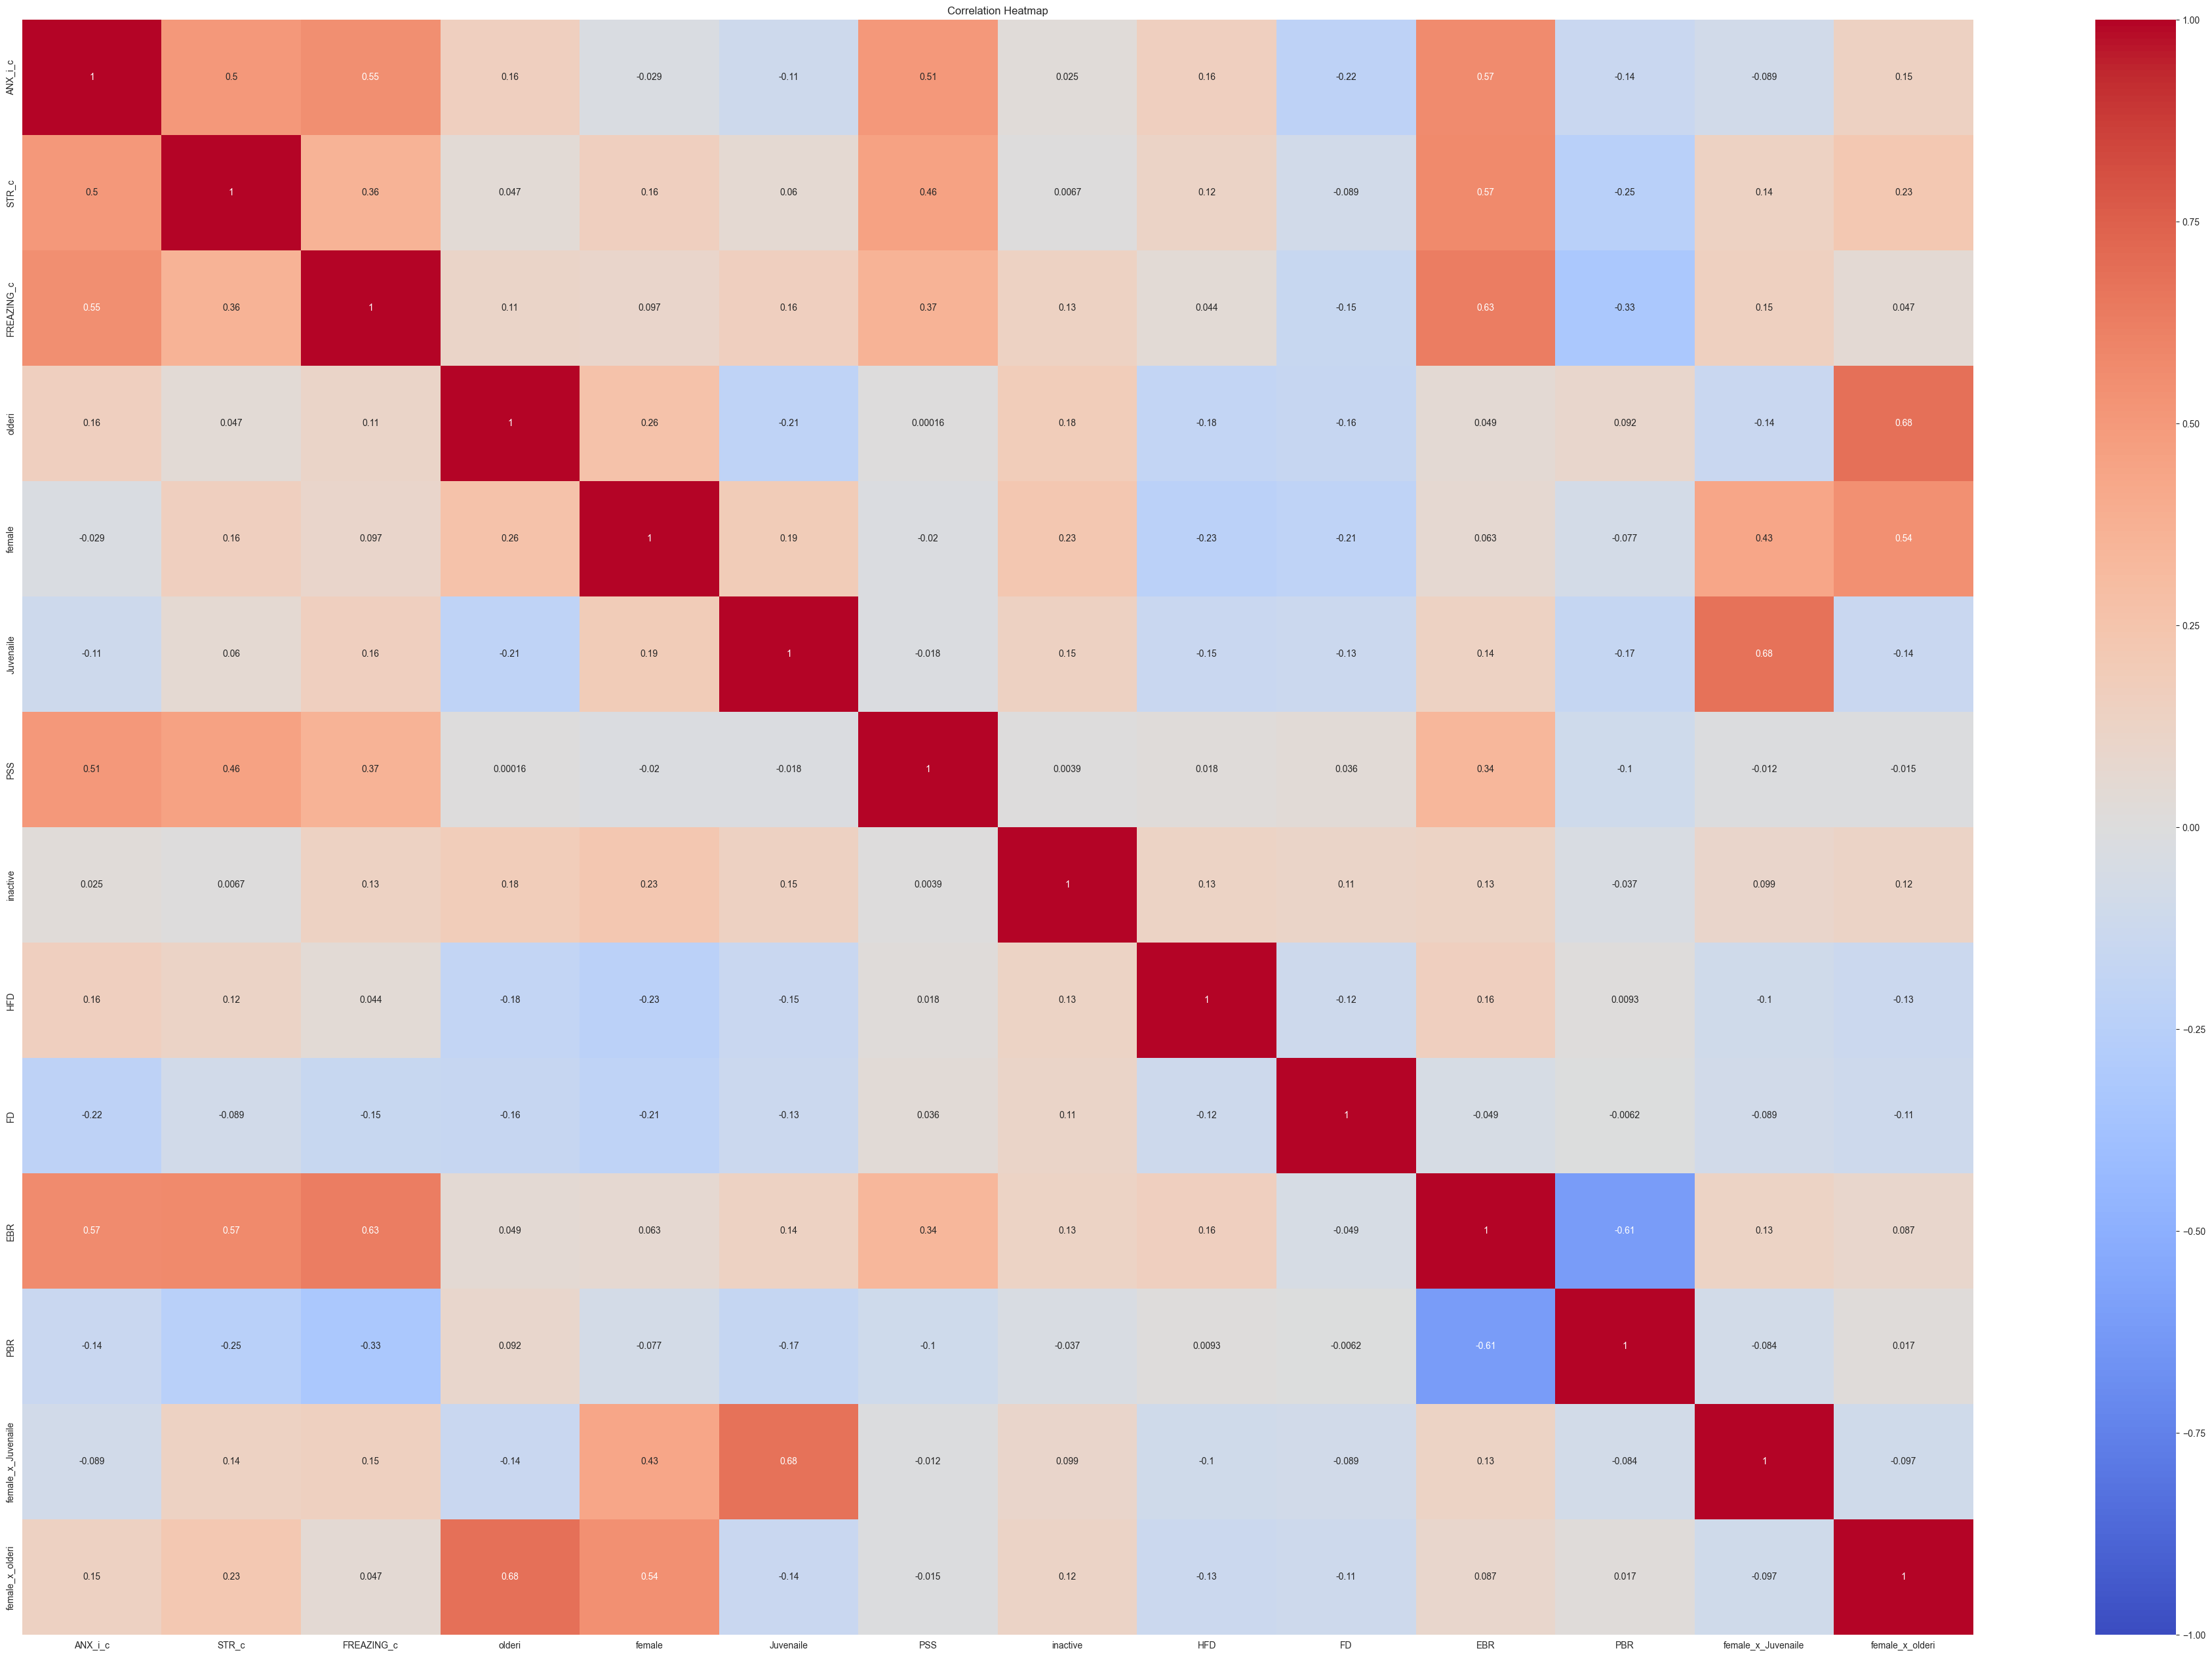


Detailed Correlation Matrix:
                     X                   Y   method alternative    n  \
0              ANX_i_c               STR_c  pearson   two-sided  556   
1              ANX_i_c          FREAZING_c  pearson   two-sided  556   
2              ANX_i_c              olderi  pearson   two-sided  556   
3              ANX_i_c              female  pearson   two-sided  556   
4              ANX_i_c           Juvenaile  pearson   two-sided  556   
..                 ...                 ...      ...         ...  ...   
86                 EBR  female_x_Juvenaile  pearson   two-sided  556   
87                 EBR     female_x_olderi  pearson   two-sided  556   
88                 PBR  female_x_Juvenaile  pearson   two-sided  556   
89                 PBR     female_x_olderi  pearson   two-sided  556   
90  female_x_Juvenaile     female_x_olderi  pearson   two-sided  556   

           r           CI95%         p-unc       BF10     power  
0   0.500290    [0.44, 0.56]  1.492239e

In [13]:
# 8. מטריצת קורלציות (שוב)

# משתנים רציפים ומרוכזים
cont_vars = ['ANX_i_c', 'STR_c', 'FREAZING_c']

# משתנים בינאריים
bin_vars = ['olderi', 'female', 'Juvenaile', 'PSS', 'inactive', 'HFD', 'FD', 'EBR', 'PBR', 'female_x_Juvenaile' , 'female_x_olderi']

# שמירת הדאטה המקורי לפני הצמצום
df_old = df.copy()

# יצירת df חדש רק עם המשתנים הרלוונטיים
df = df[cont_vars + bin_vars].copy()

# חישוב מטריצת קורלציות עם pingouin
corr = pg.pairwise_corr(df, method='pearson')

# הצגת מטריצת חום של הקורלציות
plt.figure(figsize=(48, 32))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

# הדפסת מטריצת הקורלציות המפורטת
print("\nDetailed Correlation Matrix:")
print(corr)

# רגרסיה לוגיסטית

Optimization terminated successfully.
         Current function value: 0.563770
         Iterations 6
                  OR    CI_low    CI_high         P>|z|
const       1.438318  0.775656   2.667110  2.486389e-01
olderi      2.181557  1.222137   3.894156  8.326134e-03
female      0.819166  0.498572   1.345911  4.310682e-01
Juvenaile   0.624404  0.335645   1.161585  1.370011e-01
PSS         1.491668  0.926633   2.401246  9.970085e-02
inactive    1.088694  0.551082   2.150776  8.067407e-01
HFD         1.307569  0.662744   2.579785  4.392348e-01
FD          0.601642  0.291679   1.241000  1.689825e-01
ANX_i_c     2.346612  0.392156  14.041833  3.500629e-01
STR_c       0.051100  0.011530   0.226483  9.040135e-05
FREAZING_c  0.009697  0.002140   0.043945  1.821394e-09


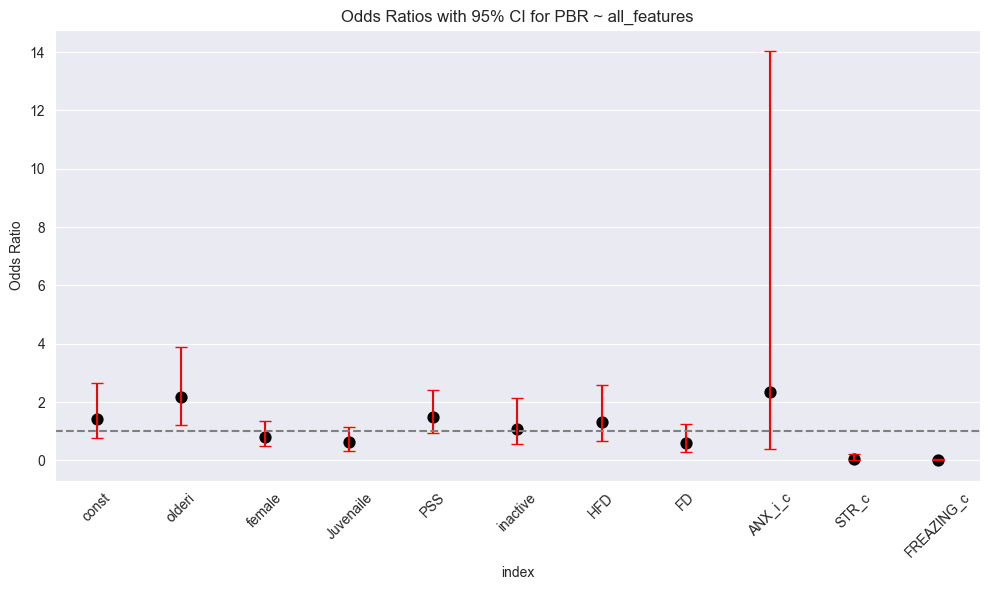

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Features and Target
features = ['olderi', 'female', 'Juvenaile', 'PSS', 'inactive', 'HFD', 'FD',
            'ANX_i_c', 'STR_c', 'FREAZING_c']
target = 'PBR'

# Drop missing values
df_log = df[features + [target]].dropna().copy()

# X and y
X = df_log[features]
y = df_log[target]

# Add constant (intercept) for statsmodels
X_sm = sm.add_constant(X)

# Fit logistic regression
model = sm.Logit(y, X_sm)
result = model.fit()

# Summary with Odds Ratios and CI
summary_df = result.summary2().tables[1]
summary_df['OR'] = np.exp(summary_df['Coef.'])  # Odds Ratio
summary_df['CI_low'] = np.exp(summary_df['Coef.'] - 1.96 * summary_df['Std.Err.'])
summary_df['CI_high'] = np.exp(summary_df['Coef.'] + 1.96 * summary_df['Std.Err.'])

# Display the table
print(summary_df[['OR', 'CI_low', 'CI_high', 'P>|z|']])

# Plot Odds Ratios with 95% CI
plt.figure(figsize=(10, 6))
sns.pointplot(data=summary_df.reset_index(), x='index', y='OR', linestyle='none', color='black')
plt.errorbar(x=np.arange(len(summary_df)),
             y=summary_df['OR'],
             yerr=[summary_df['OR'] - summary_df['CI_low'], summary_df['CI_high'] - summary_df['OR']],
             fmt='none', c='red', capsize=4)
plt.axhline(1, linestyle='--', color='gray')
plt.xticks(rotation=45)
plt.title('Odds Ratios with 95% CI for PBR ~ all_features')
plt.ylabel('Odds Ratio')
plt.tight_layout()
plt.show()

Optimization terminated successfully.
         Current function value: 0.035445
         Iterations 14
                      OR        CI_low       CI_high     P>|z|
const       4.255629e-11  4.851228e-16  3.733153e-06  0.000039
olderi      2.866913e+00  1.958396e-01  4.196897e+01  0.441765
female      1.830615e-01  1.082281e-02  3.096376e+00  0.239309
Juvenaile   1.069916e+01  2.244982e-01  5.099021e+02  0.229270
PSS         1.543784e+00  6.233330e-02  3.823430e+01  0.790868
inactive    1.709015e-01  2.847534e-03  1.025705e+01  0.397742
HFD         6.097041e+00  1.812285e-01  2.051218e+02  0.313541
FD          1.443199e+00  2.961254e-02  7.033588e+01  0.853216
ANX_i_c     9.514780e+52  2.289258e+28  3.954602e+77  0.000025
STR_c       4.002527e+06  6.805929e+01  2.353863e+11  0.006663
FREAZING_c  6.617356e+03  1.122975e+00  3.899409e+07  0.047013


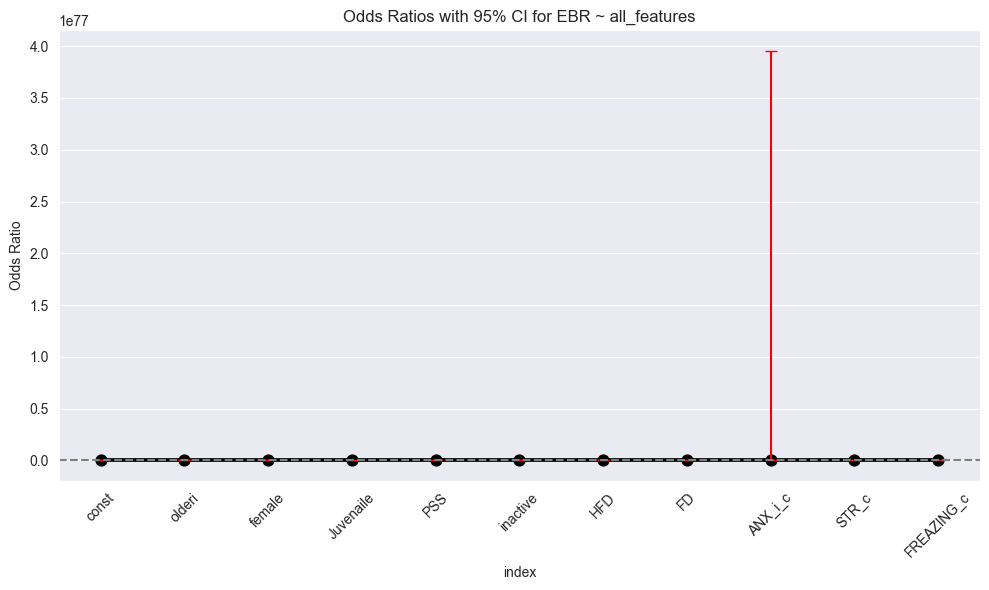

In [15]:

# Features and Target
features = ['olderi', 'female', 'Juvenaile', 'PSS', 'inactive', 'HFD', 'FD',
            'ANX_i_c', 'STR_c', 'FREAZING_c']
target = 'EBR'

# Drop missing values
df_log2 = df[features + [target]].dropna().copy()

# X and y
X = df_log2[features]
y = df_log2[target]

# Add constant (intercept) for statsmodels
X_sm = sm.add_constant(X)

# Fit logistic regression
model = sm.Logit(y, X_sm)
result = model.fit()

# Summary with Odds Ratios and CI
summary_df = result.summary2().tables[1]
summary_df['OR'] = np.exp(summary_df['Coef.'])  # Odds Ratio
summary_df['CI_low'] = np.exp(summary_df['Coef.'] - 1.96 * summary_df['Std.Err.'])
summary_df['CI_high'] = np.exp(summary_df['Coef.'] + 1.96 * summary_df['Std.Err.'])

# Display the table
print(summary_df[['OR', 'CI_low', 'CI_high', 'P>|z|']])

# Plot Odds Ratios with 95% CI
plt.figure(figsize=(10, 6))
sns.pointplot(data=summary_df.reset_index(), x='index', y='OR', color='black')
plt.errorbar(x=np.arange(len(summary_df)),
             y=summary_df['OR'],
             yerr=[summary_df['OR'] - summary_df['CI_low'], summary_df['CI_high'] - summary_df['OR']],
             fmt='none', c='red', capsize=4)
plt.axhline(1, linestyle='--', color='gray')
plt.xticks(rotation=45)
plt.title('Odds Ratios with 95% CI for EBR ~ all_features')
plt.ylabel('Odds Ratio')
plt.tight_layout()
plt.show()

הנתונים בקובץ נראים תקינים, אבל יש סיבה מאוד סבירה למה קיבלת תוצאות קיצוניות במודל הלוגיסטי (Odds Ratios ענקיים):

⸻

⚠️ הבעיה:

מסתבר ש־EBR בקובץ שלך נראה כמו משתנה בוליאני אבל הוא כנראה כל הזמן אפס או כמעט תמיד אפס. בוא נבדוק:

df['EBR'].value_counts()

אם לדוגמה 99% מהשורות הן EBR = 0, המודל לא מצליח ללמוד הבדל אמיתי — וזו הסיבה לערכי OR מוגזמים ולבעיות באומדן.


In [16]:
df['EBR'].value_counts()


EBR
0    460
1     96
Name: count, dtype: int64

•	חוסר איזון משמעותי (כ־83% מהדגימות הן 0) – וזה מסביר למה מודל הלוגיסטי שלך “מתחרפן” ומחזיר Odds Ratios קיצוניים או לא יציבים.

מודלים לוגיסטיים רגישים מאוד לאי־איזון כזה, במיוחד כשאין דגימות מגוונות.

# SEM

In [17]:

# 3. תיאור מודל SEM ()
model_desc = """
ANX_i_c      ~ PSS
STR_c        ~ PSS
FREAZING_c   ~ PSS

EBR          ~ ANX_i_c + STR_c + FREAZING_c
PBR          ~ ANX_i_c + STR_c + FREAZING_c

ANX_i_c ~~ STR_c
ANX_i_c ~~ FREAZING_c
STR_c   ~~ FREAZING_c
"""

# 5. פונקציית fitting
def fit_sem(subdf):
	m = Model(model_desc)
	m.fit(subdf)
	stats = calc_stats(m)
	return m, stats

# 6. ריצה
model, stats = fit_sem(df)

# 7. השוואת מדדי התאמה עם המפתחות הנכונים
fit_df = pd.DataFrame({
    'Chi2':stats['chi2'],'DoF':stats['DoF'],'CFI':stats['CFI'],'RMSEA':stats['RMSEA'],'AIC':stats['AIC'],'BIC':stats['BIC']})

print("\nSEM Fit Comparison PSS:")
print(fit_df.to_string())

# 8. (אופציונלי) הצגת אומדני פרמטרים
print("\nParameter Estimates PSS:")
print(model.inspect().to_string())


SEM Fit Comparison PSS:
             Chi2  DoF       CFI     RMSEA        AIC         BIC
Value  249.790059    4  0.817214  0.332741  33.101475  106.554536

Parameter Estimates PSS:
          lval  op        rval  Estimate  Std. Err    z-value       p-value
0      ANX_i_c   ~         PSS  0.157908  0.011397  13.854668  0.000000e+00
1        STR_c   ~         PSS  0.148409  0.012196  12.168607  0.000000e+00
2   FREAZING_c   ~         PSS  0.124302  0.013362   9.302634  0.000000e+00
3          EBR   ~     ANX_i_c  0.428260  0.089273   4.797218  1.608842e-06
4          EBR   ~       STR_c  0.774444  0.077195  10.032268  0.000000e+00
5          EBR   ~  FREAZING_c  0.927481  0.076363  12.145756  0.000000e+00
6          PBR   ~     ANX_i_c  0.433177  0.156888   2.761063  5.761348e-03
7          PBR   ~       STR_c -0.587900  0.135663  -4.333528  1.467387e-05
8          PBR   ~  FREAZING_c -0.943161  0.134200  -7.028041  2.094547e-12
9      ANX_i_c  ~~       STR_c  0.006740  0.000866   7.77

In [18]:

# ---------- 2. ריצה יחידה וחילוץ נתיבים ----------
def single_run(data, model_desc):
    """מחזיר dict עם כל הנתיבים הישירים + כל הנתיבים העקיפים (X→M→Y)."""
    m = Model(model_desc)
    m.fit(data, obj="MLW")
    est = m.inspect()

    # --- נתיבים ישירים ---
    direct = {(row.lval, row.rval): row.Estimate
              for _, row in est[est.op == "~"].iterrows()}

    # --- מציאת כל X→M→Y האפשריים ---
    indirect = {}
    # אקסוגניות: משתנים שמופיעים רק כ-predictors (אין להם חץ נכנס)
    lhs_set = set(k[0] for k in direct)
    exogenous = set(k[1] for k in direct) - lhs_set

    for (m, x), a in direct.items():      # x → m
        for (y, m2), b in direct.items(): # m → y
            if m == m2 and x != y:        # אותה חוליה, אין מסלול מקוצר
                # נדרש שמקור המסלול יהיה אקסוגני (לפי רוב ניתוחי מֶדיאציה)
                if x in exogenous:
                    indirect[f"{x} → {m} → {y}"] = a * b

    # החזרת COMBINED dict
    return {**{f"{k[0]} ← {k[1]}": v for k, v in direct.items()},
            **indirect}

# ---------- 3. Bootstrap ----------
def bootstrap_sem(model_desc, data: pd.DataFrame,
                  n_boot: int = 2000,
                  random_state: int | None = None
                 , ) -> tuple[pd.DataFrame, pd.DataFrame]:

    rng, rows = np.random.default_rng(random_state), []
    for _ in range(n_boot):
        resample = data.sample(len(data), replace=True,
                               random_state=rng.integers(1e9))
        try:
            rows.append(single_run(resample , model_desc))
        except Exception:
            continue

    boot_df = pd.DataFrame(rows)


    # ---------- טבלת סיכום ----------
    summ = (boot_df.agg(['mean', 'std']).T
            .rename(columns={'mean': 'Estimate', 'std': 'SE'}))
    summ['CI_lo']   = boot_df.quantile(0.025)
    summ['CI_hi']   = boot_df.quantile(0.975)
    summ['CI_w']    = summ['CI_hi'] - summ['CI_lo']          # רוחב CI
    summ['Z']       = summ['Estimate'] / summ['SE']          # Z-score

    # p-value לא-פרמטרי: 2·min(P(<0), P(>0))
    pvals = boot_df.apply(
        lambda col: 2 * min((col <= 0).mean(), (col >= 0).mean()),
        axis=0)
    summ['p_boot'] = pvals

    # סמן מובהקות לפי p<0.05 (או CI שלא חותך 0)
    summ['Sig (p<.05)'] = summ['p_boot'] < .05

    return boot_df, summ


# ---------- 4. הפעלה ----------
boot_df, full_summary = bootstrap_sem(model_desc,df, n_boot=2000)

# --- נתיבים ישירים ---
direct_summary = full_summary[full_summary.index.str.contains("←")]

#     טבלת תיווכים בלבד
indirect_summary = full_summary[full_summary.index.str.contains("→")]



print("\nאפקטים ישירים – Bootstrap:")
print(direct_summary.round(3).to_string())

print("\nאפקטים עקיפים (תיווך) – Bootstrap:")
print(indirect_summary.round(3).to_string())




אפקטים ישירים – Bootstrap:
                  Estimate     SE  CI_lo  CI_hi   CI_w       Z  p_boot  Sig (p<.05)
ANX_i_c ← PSS        0.158  0.012  0.136  0.180  0.045  13.633   0.000         True
STR_c ← PSS          0.148  0.012  0.125  0.174  0.048  12.149   0.000         True
FREAZING_c ← PSS     0.124  0.013  0.098  0.150  0.052   9.266   0.000         True
EBR ← ANX_i_c        0.431  0.088  0.255  0.605  0.350   4.870   0.000         True
EBR ← STR_c          0.775  0.092  0.593  0.955  0.362   8.435   0.000         True
EBR ← FREAZING_c     0.926  0.083  0.764  1.085  0.320  11.176   0.000         True
PBR ← ANX_i_c        0.439  0.168  0.119  0.767  0.649   2.612   0.006         True
PBR ← STR_c         -0.592  0.148 -0.895 -0.311  0.585  -4.015   0.000         True
PBR ← FREAZING_c    -0.941  0.126 -1.189 -0.694  0.495  -7.458   0.000         True

אפקטים עקיפים (תיווך) – Bootstrap:
                        Estimate     SE  CI_lo  CI_hi   CI_w      Z  p_boot  Sig (p<.05)
PSS → A

SEM diagram for PSS saved as sem_diagram_pss.png


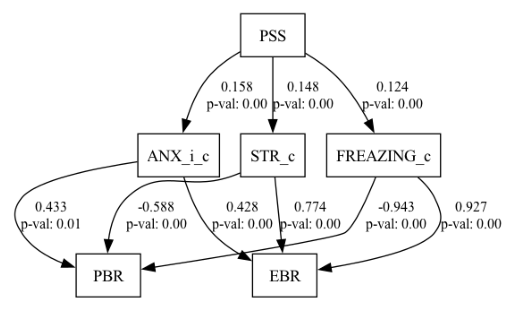

In [19]:
# הפקת דיאגרמת SEM עבור PSS
semplot(model, "sem_diagram_pss.png")
print("SEM diagram for PSS saved as sem_diagram_pss.png")
plt.imshow(plt.imread("sem_diagram_pss.png"))
plt.axis('off')  # להסתיר את הצירים
plt.show()

## פיצול הנתונים וריצה עם מודל מפוצל לפי PSS 1/0

In [14]:
# =====================================================================
# 3. תיאור מודל SEM (ללא PSS בתוך המשוואות)
model_desc = """
ANX_i_c      ~ olderi + female + Juvenaile + inactive + HFD + FD + female_x_olderi + female_x_Juvenaile
STR_c        ~ olderi + female + Juvenaile + inactive + HFD + FD + female_x_olderi + female_x_Juvenaile
FREAZING_c   ~ olderi + female + Juvenaile + inactive + HFD + FD + female_x_olderi + female_x_Juvenaile

EBR          ~ ANX_i_c + STR_c + FREAZING_c
PBR          ~ ANX_i_c + STR_c + FREAZING_c

ANX_i_c ~~ STR_c
ANX_i_c ~~ FREAZING_c
STR_c   ~~ FREAZING_c
"""

# 4. פיצול הדאטה
df0 = df[df['PSS'] == 0].copy()
df1 = df[df['PSS'] == 1].copy()


New Variance Inflation Factors (VIF):
              Variable       VIF
0              ANX_i_c  1.899367
1                STR_c  1.936392
2           FREAZING_c  1.296379
3               olderi  2.753174
4               female  2.880944
5            Juvenaile  2.419577
6             inactive  1.421942
7                  HFD  1.567316
8                   FD  1.694911
9                  EBR  1.874923
10                 PBR  1.314650
11  female_x_Juvenaile  3.026076
12     female_x_olderi  4.104322


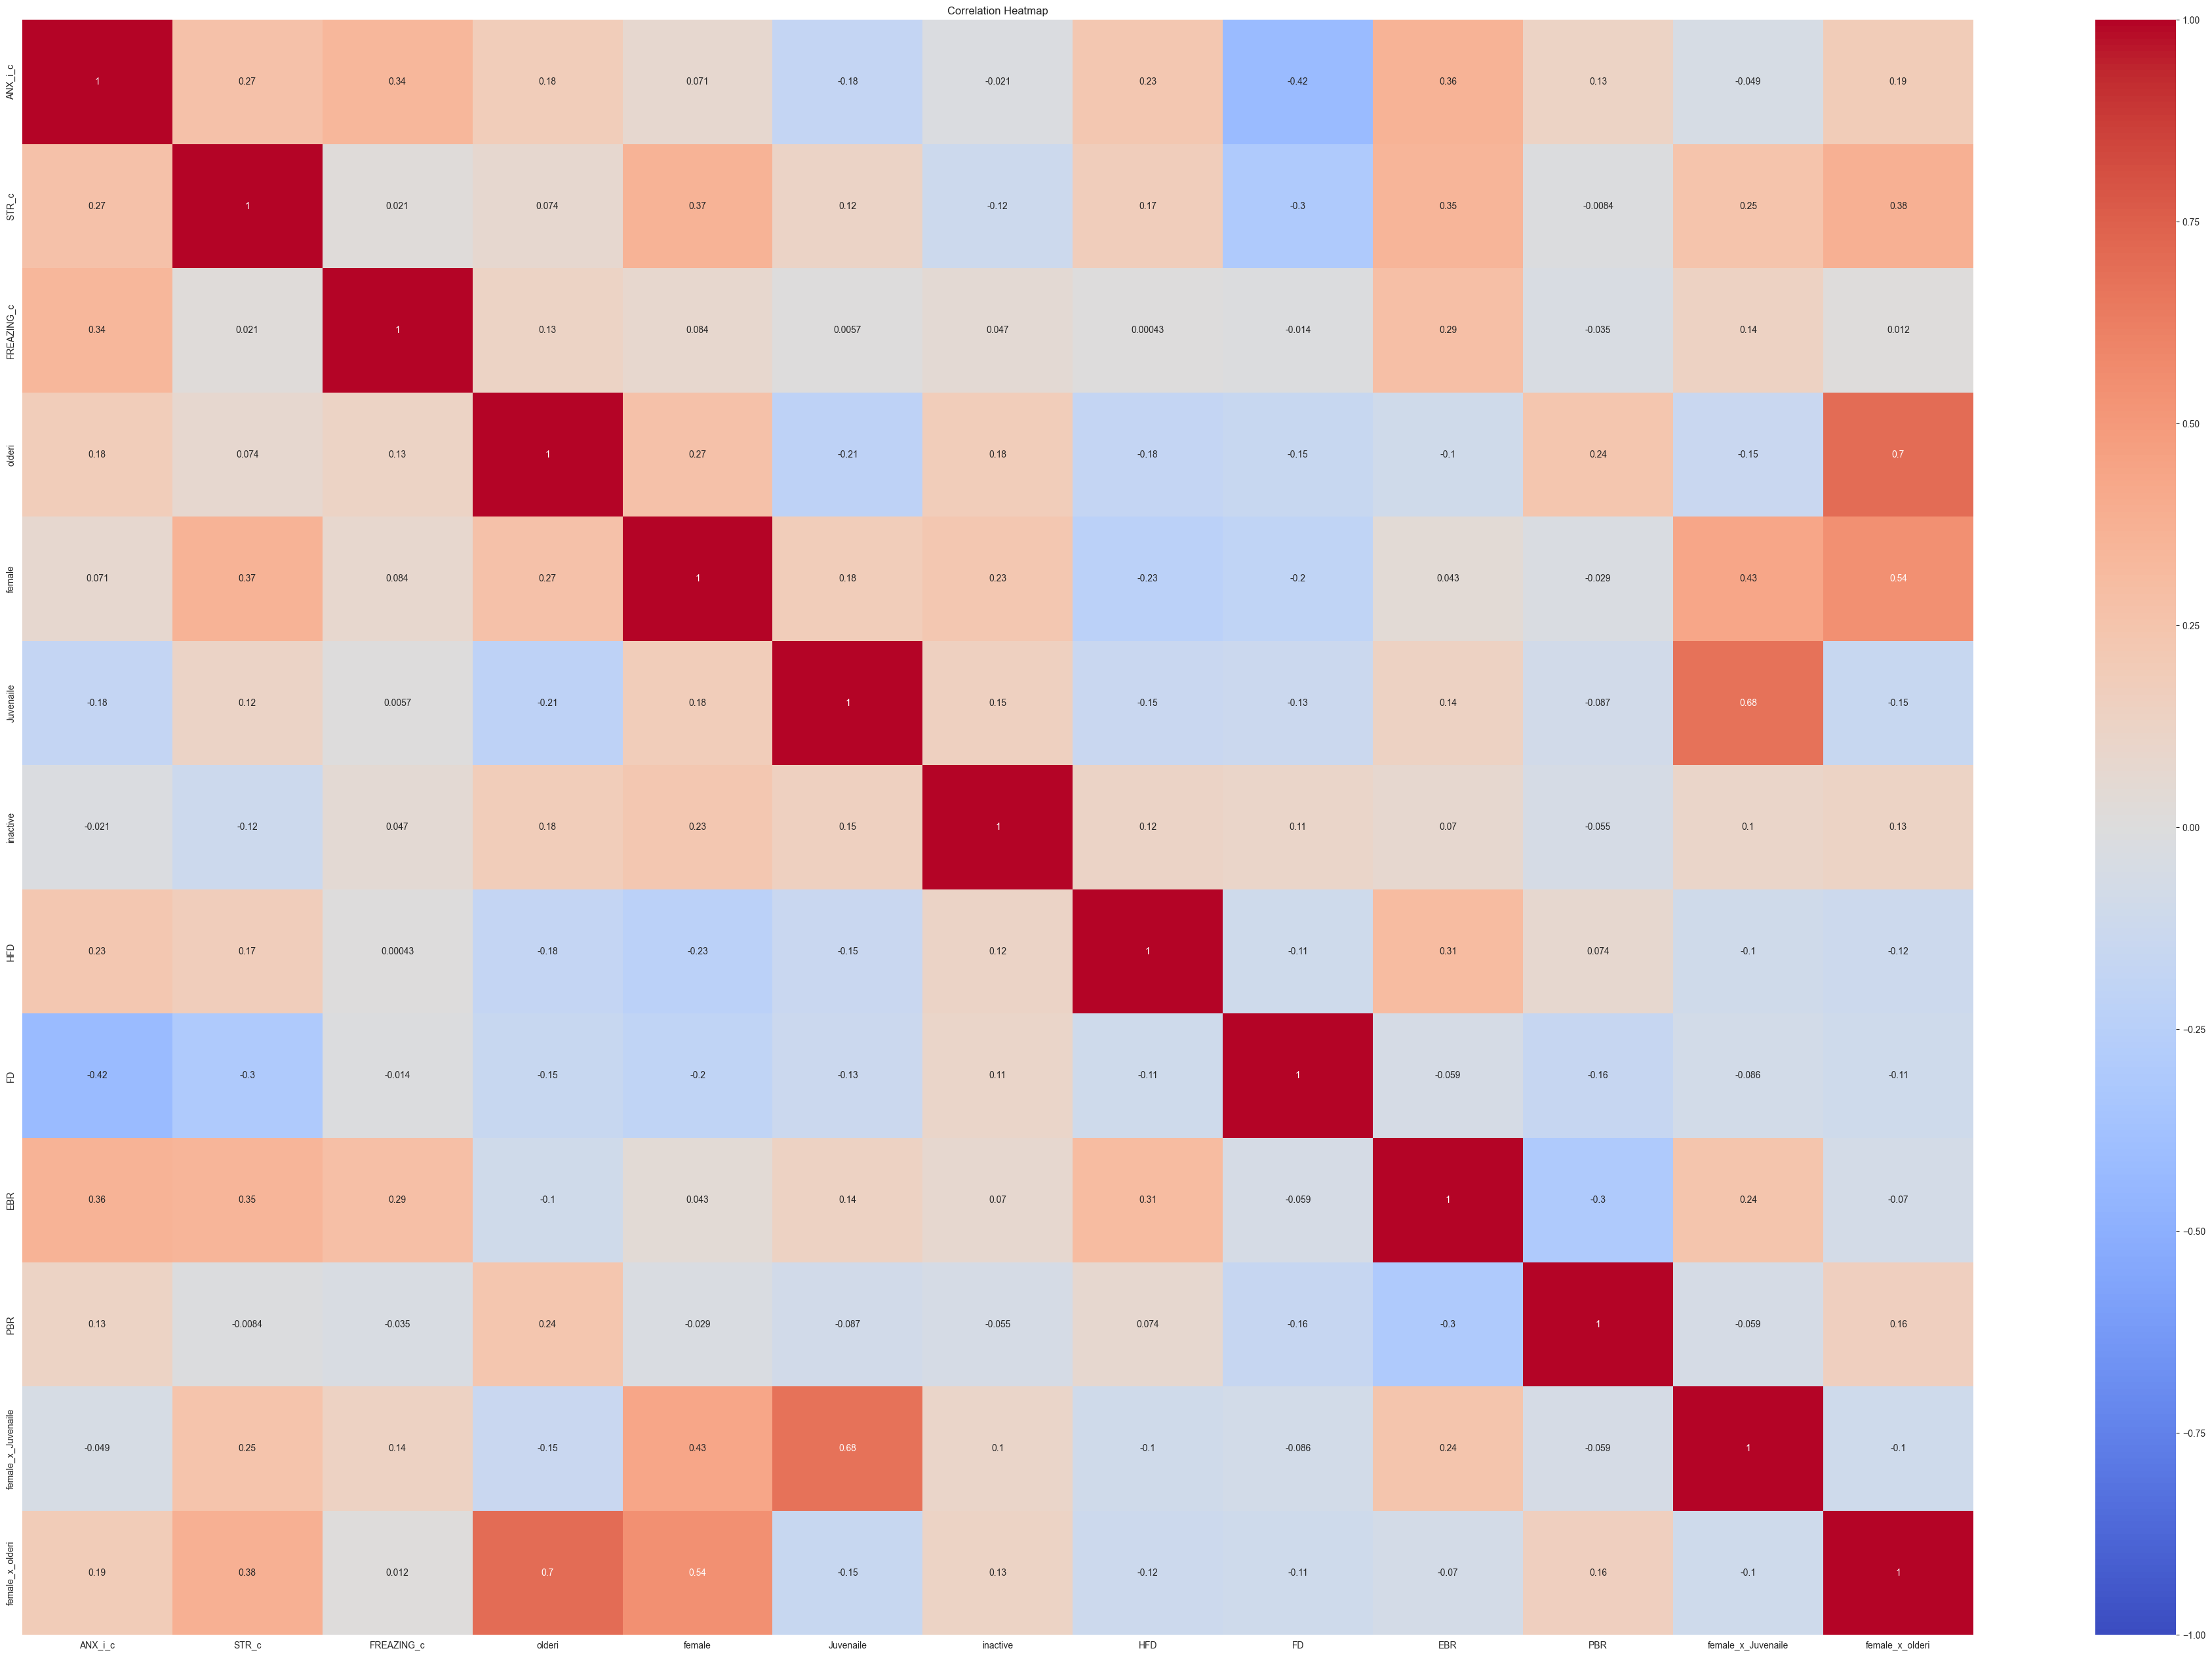


Detailed Correlation Matrix:
                     X                   Y   method alternative    n  \
0              ANX_i_c               STR_c  pearson   two-sided  266   
1              ANX_i_c          FREAZING_c  pearson   two-sided  266   
2              ANX_i_c              olderi  pearson   two-sided  266   
3              ANX_i_c              female  pearson   two-sided  266   
4              ANX_i_c           Juvenaile  pearson   two-sided  266   
..                 ...                 ...      ...         ...  ...   
73                 EBR  female_x_Juvenaile  pearson   two-sided  266   
74                 EBR     female_x_olderi  pearson   two-sided  266   
75                 PBR  female_x_Juvenaile  pearson   two-sided  266   
76                 PBR     female_x_olderi  pearson   two-sided  266   
77  female_x_Juvenaile     female_x_olderi  pearson   two-sided  266   

           r           CI95%         p-unc       BF10     power  
0   0.266874    [0.15, 0.38]  1.022415e

In [15]:
df0 = df0.drop(columns=['PSS'])

# חישוב VIF מחדש אחרי חלוקה
X = df0.assign(const=1)

vif_data = pd.DataFrame({
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# מסנן החוצה את הקבוע מהתצוגה
vif_data = vif_data[vif_data['Variable'] != 'const']

print("\nNew Variance Inflation Factors (VIF):")
print(vif_data)

# 8. מטריצת קורלציות (שוב)

# משתנים רציפים ומרוכזים
cont_vars = ['ANX_i_c', 'STR_c', 'FREAZING_c']

# משתנים בינאריים
bin_vars = ['olderi', 'female', 'Juvenaile', 'inactive', 'HFD', 'FD', 'EBR', 'PBR', 'female_x_Juvenaile' , 'female_x_olderi']

# שמירת הדאטה המקורי לפני הצמצום
df_0old = df0.copy()

# יצירת df חדש רק עם המשתנים הרלוונטיים
df0 = df0[cont_vars + bin_vars].copy()

# חישוב מטריצת קורלציות עם pingouin
corr = pg.pairwise_corr(df0, method='pearson')

# הצגת מטריצת חום של הקורלציות
plt.figure(figsize=(48, 32))
sns.heatmap(df0.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

# הדפסת מטריצת הקורלציות המפורטת
print("\nDetailed Correlation Matrix:")
print(corr)



New Variance Inflation Factors (VIF):
              Variable       VIF
0              ANX_i_c  2.674581
1                STR_c  1.665353
2           FREAZING_c  2.475759
3               olderi  2.457515
4               female  3.141648
5            Juvenaile  2.629387
6             inactive  1.474311
7                  HFD  1.431947
8                   FD  1.467654
9                  EBR  6.741328
10                 PBR  3.482554
11  female_x_Juvenaile  3.022701
12     female_x_olderi  3.398718


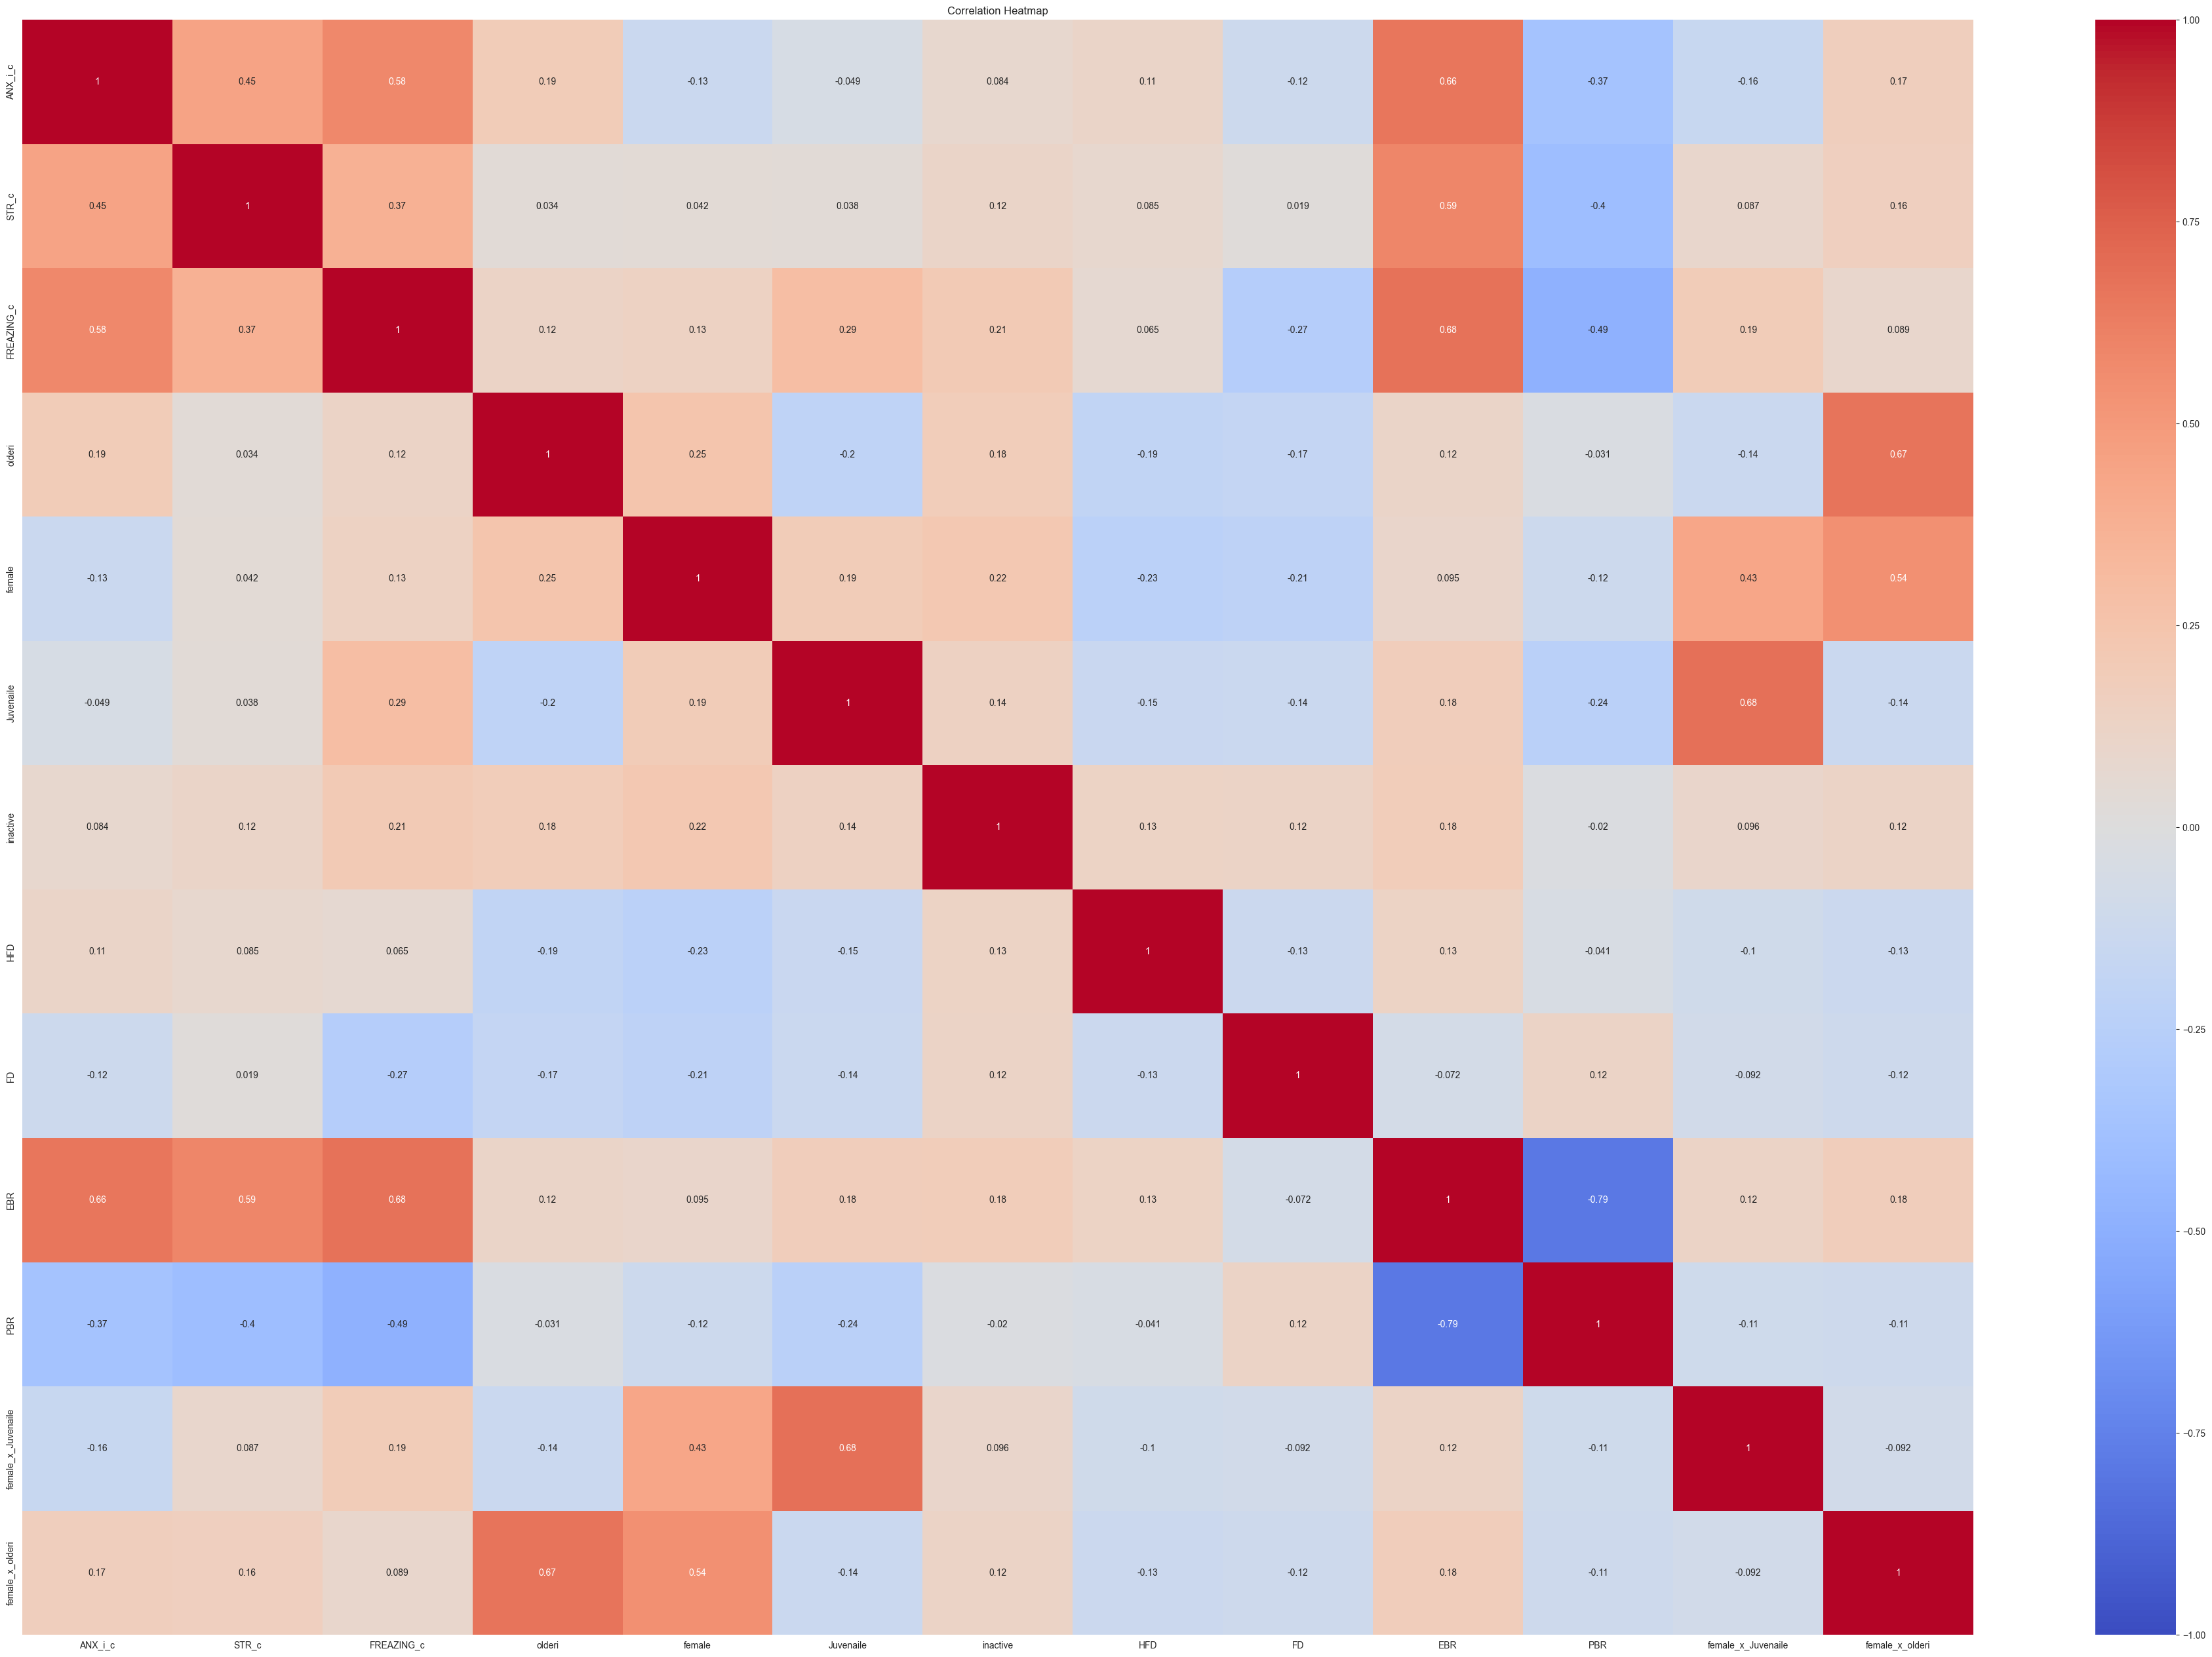


Detailed Correlation Matrix:
                     X                   Y   method alternative    n  \
0              ANX_i_c               STR_c  pearson   two-sided  290   
1              ANX_i_c          FREAZING_c  pearson   two-sided  290   
2              ANX_i_c              olderi  pearson   two-sided  290   
3              ANX_i_c              female  pearson   two-sided  290   
4              ANX_i_c           Juvenaile  pearson   two-sided  290   
..                 ...                 ...      ...         ...  ...   
73                 EBR  female_x_Juvenaile  pearson   two-sided  290   
74                 EBR     female_x_olderi  pearson   two-sided  290   
75                 PBR  female_x_Juvenaile  pearson   two-sided  290   
76                 PBR     female_x_olderi  pearson   two-sided  290   
77  female_x_Juvenaile     female_x_olderi  pearson   two-sided  290   

           r           CI95%         p-unc       BF10     power  
0   0.450852    [0.35, 0.54]  6.326796e

In [16]:
df1 = df1.drop(columns=['PSS'])

# חישוב VIF מחדש אחרי חלוקה
X = df1.assign(const=1)

vif_data = pd.DataFrame({
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# מסנן החוצה את הקבוע מהתצוגה
vif_data = vif_data[vif_data['Variable'] != 'const']

print("\nNew Variance Inflation Factors (VIF):")
print(vif_data)

# 8. מטריצת קורלציות (שוב)

# משתנים רציפים ומרוכזים
cont_vars = ['ANX_i_c', 'STR_c', 'FREAZING_c']

# משתנים בינאריים
bin_vars = ['olderi', 'female', 'Juvenaile', 'inactive', 'HFD', 'FD', 'EBR', 'PBR', 'female_x_Juvenaile' , 'female_x_olderi']

# שמירת הדאטה המקורי לפני הצמצום
df_1old = df1.copy()

# יצירת df חדש רק עם המשתנים הרלוונטיים
df1 = df1[cont_vars + bin_vars].copy()

# חישוב מטריצת קורלציות עם pingouin
corr = pg.pairwise_corr(df1, method='pearson')

# הצגת מטריצת חום של הקורלציות
plt.figure(figsize=(48, 32))
sns.heatmap(df1.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

# הדפסת מטריצת הקורלציות המפורטת
print("\nDetailed Correlation Matrix:")
print(corr)


In [17]:


# 6. ריצה
model, stats = fit_sem(df0)

# 7. השוואת מדדי התאמה עם המפתחות הנכונים
fit_df = pd.DataFrame({
    'Chi2':stats['chi2'],'DoF':stats['DoF'],'CFI':stats['CFI'],'RMSEA':stats['RMSEA'],'AIC':stats['AIC'],'BIC':stats['BIC']})

print("\nSEM Fit Comparison PSS_0:")
print(fit_df.to_string())

# 8. (אופציונלי) הצגת אומדני פרמטרים
print("\nParameter Estimates PSS_0:")
print(model.inspect().to_string())


SEM Fit Comparison PSS_0:
             Chi2  DoF       CFI     RMSEA       AIC         BIC
Value  121.196298   53  0.939586  0.069682  75.08875  211.261609

Parameter Estimates PSS_0:
          lval  op                rval  Estimate  Std. Err    z-value       p-value
0      ANX_i_c   ~              olderi -0.007064  0.030254  -0.233479  8.153894e-01
1      ANX_i_c   ~              female -0.047358  0.028418  -1.666447  9.562449e-02
2      ANX_i_c   ~           Juvenaile -0.128406  0.032815  -3.913078  9.112722e-05
3      ANX_i_c   ~            inactive  0.019661  0.028418   0.691840  4.890377e-01
4      ANX_i_c   ~                 HFD  0.071018  0.028743   2.470770  1.348226e-02
5      ANX_i_c   ~                  FD -0.241643  0.031676  -7.628528  2.375877e-14
6      ANX_i_c   ~     female_x_olderi  0.106111  0.044633   2.377430  1.743376e-02
7      ANX_i_c   ~  female_x_Juvenaile  0.121386  0.049222   2.466088  1.365976e-02
8        STR_c   ~              olderi -0.089909  0.024989 

In [18]:


# ---------- 4. הפעלה ----------
boot_df0, full_summary_pss0 = bootstrap_sem(model_desc,df0, n_boot=2000)

# --- נתיבים ישירים ---
direct_summary = full_summary_pss0[full_summary_pss0.index.str.contains("←")]

#     טבלת תיווכים בלבד
indirect_summary = full_summary_pss0[full_summary_pss0.index.str.contains("→")]



print("\nאפקטים ישירים – Bootstrap PSS_0:")
print(direct_summary.round(3).to_string())

print("\nאפקטים עקיפים (תיווך) – Bootstrap PSS_0:")
print(indirect_summary.round(3).to_string())



אפקטים ישירים – Bootstrap PSS_0:
                                 Estimate     SE  CI_lo  CI_hi   CI_w      Z  p_boot  Sig (p<.05)
ANX_i_c ← olderi                   -0.006  0.029 -0.061  0.050  0.111 -0.226   0.849        False
ANX_i_c ← female                   -0.048  0.030 -0.106  0.010  0.116 -1.601   0.099        False
ANX_i_c ← Juvenaile                -0.127  0.036 -0.200 -0.058  0.142 -3.509   0.000         True
ANX_i_c ← inactive                  0.019  0.027 -0.032  0.073  0.105  0.713   0.496        False
ANX_i_c ← HFD                       0.071  0.027  0.019  0.122  0.104  2.598   0.010         True
ANX_i_c ← FD                       -0.241  0.035 -0.312 -0.174  0.138 -6.785   0.000         True
ANX_i_c ← female_x_olderi           0.107  0.042  0.024  0.189  0.165  2.561   0.012         True
ANX_i_c ← female_x_Juvenaile        0.122  0.062  0.003  0.249  0.246  1.977   0.047         True
STR_c ← olderi                     -0.089  0.017 -0.124 -0.055  0.069 -5.118   0.000

SEM diagram for PSS saved as sem_diagram_pss_0.png


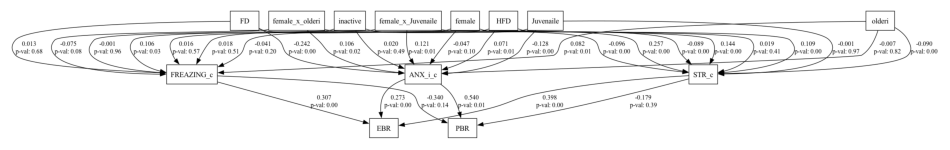

In [19]:
# הפקת דיאגרמת SEM עבור PSS
semplot(model, "sem_diagram_pss_0.png")
print("SEM diagram for PSS saved as sem_diagram_pss_0.png")
plt.figure(figsize=(12, 8))  # קובע את גודל החלון
plt.imshow(plt.imread("sem_diagram_pss_0.png"))
plt.axis('off')  # להסתיר את הצירים
plt.show()

In [20]:


# 6. ריצה
model, stats = fit_sem(df1)

# 7. השוואת מדדי התאמה עם המפתחות הנכונים
fit_df1 = pd.DataFrame({
    'Chi2':stats['chi2'],'DoF':stats['DoF'],'CFI':stats['CFI'],'RMSEA':stats['RMSEA'],'AIC':stats['AIC'],'BIC':stats['BIC']})

print("\nSEM Fit Comparison PSS_1:")
print(fit_df1.to_string())

# 8. (אופציונלי) הצגת אומדני פרמטרים
print("\nParameter Estimates PSS_1:")
print(model.inspect().to_string())


SEM Fit Comparison PSS_1:
             Chi2  DoF       CFI     RMSEA        AIC        BIC
Value  281.728471   53  0.866427  0.122201  74.057045  213.51252

Parameter Estimates PSS_1:
          lval  op                rval  Estimate  Std. Err    z-value       p-value
0      ANX_i_c   ~              olderi  0.010002  0.024078   0.415382  6.778625e-01
1      ANX_i_c   ~              female -0.097512  0.023568  -4.137415  3.512405e-05
2      ANX_i_c   ~           Juvenaile  0.017290  0.027822   0.621435  5.343136e-01
3      ANX_i_c   ~            inactive  0.048754  0.023568   2.068645  3.857944e-02
4      ANX_i_c   ~                 HFD  0.013884  0.022896   0.606378  5.442640e-01
5      ANX_i_c   ~                  FD -0.061632  0.024078  -2.559692  1.047651e-02
6      ANX_i_c   ~     female_x_olderi  0.125159  0.036506   3.428414  6.071188e-04
7      ANX_i_c   ~  female_x_Juvenaile -0.007455  0.041489  -0.179694  8.573931e-01
8        STR_c   ~              olderi -0.071229  0.031621 

In [21]:

# ---------- 4. הפעלה ----------
boot_df1, full_summary_pss1 = bootstrap_sem(model_desc,df1, n_boot=2000)

# --- נתיבים ישירים ---
direct_summary = full_summary_pss1[full_summary_pss1.index.str.contains("←")]

#     טבלת תיווכים בלבד
indirect_summary = full_summary_pss1[full_summary_pss1.index.str.contains("→")]



print("\nאפקטים ישירים – Bootstrap PSS_1:")
print(direct_summary.round(3).to_string())

print("\nאפקטים עקיפים (תיווך) – Bootstrap PSS_1:")
print(indirect_summary.round(3).to_string())





אפקטים ישירים – Bootstrap PSS_1:
                                 Estimate     SE  CI_lo  CI_hi   CI_w      Z  p_boot  Sig (p<.05)
ANX_i_c ← olderi                    0.011  0.017 -0.022  0.043  0.065  0.636   0.522        False
ANX_i_c ← female                   -0.097  0.024 -0.144 -0.048  0.096 -4.032   0.000         True
ANX_i_c ← Juvenaile                 0.018  0.025 -0.031  0.065  0.096  0.712   0.481        False
ANX_i_c ← inactive                  0.049  0.019  0.012  0.087  0.075  2.571   0.008         True
ANX_i_c ← HFD                       0.013  0.020 -0.027  0.053  0.080  0.677   0.487        False
ANX_i_c ← FD                       -0.062  0.027 -0.120 -0.011  0.109 -2.267   0.020         True
ANX_i_c ← female_x_olderi           0.124  0.031  0.060  0.184  0.124  3.964   0.000         True
ANX_i_c ← female_x_Juvenaile       -0.008  0.057 -0.121  0.101  0.222 -0.147   0.875        False
STR_c ← olderi                     -0.071  0.034 -0.137 -0.006  0.131 -2.106   0.033

SEM diagram for PSS saved as sem_diagram_pss_1.png


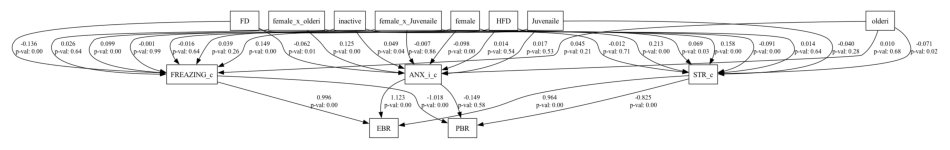

In [22]:
# הפקת דיאגרמת SEM עבור PSS
semplot(model, "sem_diagram_pss_1.png")
print("SEM diagram for PSS saved as sem_diagram_pss_1.png")
plt.figure(figsize=(12, 8))  # קובע את גודל החלון
plt.imshow(plt.imread("sem_diagram_pss_1.png"))
plt.axis('off')  # להסתיר את הצירים
plt.show()

In [23]:
from semopy import Model, gather_statistics
from scipy.stats import chi2

# הגדרת המודל
model_joint = Model(model_desc)
model_joint.fit(df)
stats_joint = gather_statistics(model_joint)
chi2_joint = stats_joint.chi2[0]
df_joint = stats_joint.dof

# מודלים נפרדים
model_0 = Model(model_desc)
model_0.fit(df0)
stats_0 = gather_statistics(model_0)
chi2_0 = stats_0.chi2[0]
df_0 = stats_0.dof

model_1 = Model(model_desc)
model_1.fit(df1)
stats_1 = gather_statistics(model_1)
chi2_1 = stats_1.chi2[0]
df_1 = stats_1.dof

# השוואת χ² בין המודלים
chi2_split = chi2_0 + chi2_1
df_split = df_0 + df_1

delta_chi2 = chi2_split - chi2_joint
delta_df = df_split - df_joint
p_value = 1 - chi2.cdf(delta_chi2, delta_df)

print("\n🔍 ΔChi² בין מודל מאוחד למפוצל:")
print(f"ΔChi² = {delta_chi2:.3f}, Δdf = {delta_df}, p = {p_value:.4f}")
if p_value < 0.05:
    print("✅ יש הבדל מובהק בין הקבוצות – מודלים נפרדים מתאימים יותר.")
else:
    print("❌ אין הבדל מובהק – אפשר להשתמש במודל מאוחד.")


🔍 ΔChi² בין מודל מאוחד למפוצל:
ΔChi² = 87.826, Δdf = 53, p = 0.0019
✅ יש הבדל מובהק בין הקבוצות – מודלים נפרדים מתאימים יותר.


In [24]:
from semopy import Model
from semopy.inspector import inspect
from scipy.stats import chi2

def test_param_invariance(model_desc, df0, df1, param_label):
    # התאמת מודלים נפרדים לכל קבוצה
    m0 = Model(model_desc)
    m1 = Model(model_desc)
    m0.fit(df0)
    m1.fit(df1)

    # שליפת ערכים ומטריצות
    est0 = inspect(m0).set_index(['lval', 'op', 'rval'])
    est1 = inspect(m1).set_index(['lval', 'op', 'rval'])

    # שליפת הערכה וסטיית תקן
    if param_label not in est0.index or param_label not in est1.index:
        print(f"{param_label}: ❌ לא קיים במודל")
        return

    b0 = est0.loc[param_label, 'Estimate']
    se0 = est0.loc[param_label, 'Std. Err']
    b1 = est1.loc[param_label, 'Estimate']
    se1 = est1.loc[param_label, 'Std. Err']

    # מבחן Z בין האומדנים
    z = (b0 - b1) / (se0**2 + se1**2)**0.5
    p = 2 * (1 - chi2.cdf(z**2, 1))

    # הדפסה
    print(f"{param_label}: Δβ = {b0 - b1:.3f}, Z = {z:.2f}, p = {p:.4f} → {'✅ שונה מובהק' if p < 0.05 else '❌ לא שונה'}")

# 🧪 דוגמה: לבדוק הבדלים בין הקבוצות
to_test = [
    ('ANX_i_c', '~', 'olderi'),
    ('ANX_i_c', '~', 'female'),
    ('ANX_i_c', '~', 'Juvenaile'),
    ('ANX_i_c', '~', 'inactive'),
    ('ANX_i_c', '~', 'HFD'),
    ('ANX_i_c', '~', 'FD'),
    ('ANX_i_c', '~', 'female_x_olderi'),
    ('ANX_i_c', '~', 'female_x_Juvenaile'),

    ('STR_c', '~', 'olderi'),
    ('STR_c', '~', 'female'),
    ('STR_c', '~', 'Juvenaile'),
    ('STR_c', '~', 'inactive'),
    ('STR_c', '~', 'HFD'),
    ('STR_c', '~', 'FD'),
    ('STR_c', '~', 'female_x_olderi'),
    ('STR_c', '~', 'female_x_Juvenaile'),

    ('FREAZING_c', '~', 'olderi'),
    ('FREAZING_c', '~', 'female'),
    ('FREAZING_c', '~', 'Juvenaile'),
    ('FREAZING_c', '~', 'inactive'),
    ('FREAZING_c', '~', 'HFD'),
    ('FREAZING_c', '~', 'FD'),
    ('FREAZING_c', '~', 'female_x_olderi'),
    ('FREAZING_c', '~', 'female_x_Juvenaile'),

    ('EBR', '~', 'ANX_i_c'),
    ('EBR', '~', 'STR_c'),
    ('EBR', '~', 'FREAZING_c'),

    ('PBR', '~', 'ANX_i_c'),
    ('PBR', '~', 'STR_c'),
    ('PBR', '~', 'FREAZING_c')
]

for param in to_test:
    test_param_invariance(model_desc, df0, df1, param)

('ANX_i_c', '~', 'olderi'): Δβ = -0.017, Z = -0.44, p = 1.3179 → ❌ לא שונה
('ANX_i_c', '~', 'female'): Δβ = 0.050, Z = 1.36, p = 0.3486 → ❌ לא שונה
('ANX_i_c', '~', 'Juvenaile'): Δβ = -0.146, Z = -3.39, p = 0.0014 → ✅ שונה מובהק
('ANX_i_c', '~', 'inactive'): Δβ = -0.029, Z = -0.79, p = 0.8614 → ❌ לא שונה
('ANX_i_c', '~', 'HFD'): Δβ = 0.057, Z = 1.55, p = 0.2400 → ❌ לא שונה
('ANX_i_c', '~', 'FD'): Δβ = -0.180, Z = -4.52, p = 0.0000 → ✅ שונה מובהק
('ANX_i_c', '~', 'female_x_olderi'): Δβ = -0.019, Z = -0.33, p = 1.4823 → ❌ לא שונה
('ANX_i_c', '~', 'female_x_Juvenaile'): Δβ = 0.129, Z = 2.00, p = 0.0907 → ❌ לא שונה
('STR_c', '~', 'olderi'): Δβ = -0.019, Z = -0.46, p = 1.2860 → ❌ לא שונה
('STR_c', '~', 'female'): Δβ = 0.110, Z = 2.84, p = 0.0090 → ✅ שונה מובהק
('STR_c', '~', 'Juvenaile'): Δβ = 0.039, Z = 0.85, p = 0.7857 → ❌ לא שונה
('STR_c', '~', 'inactive'): Δβ = -0.158, Z = -4.06, p = 0.0001 → ✅ שונה מובהק
('STR_c', '~', 'HFD'): Δβ = 0.095, Z = 2.49, p = 0.0258 → ✅ שונה מובהק
('STR_c', '

In [25]:
import pandas as pd

# הגדר את הרשימה (אם לא עשית קודם)
indirect_params = [
    "olderi → ANX_i_c → EBR",
    "olderi → ANX_i_c → PBR",
    "female → ANX_i_c → EBR",
    "female → ANX_i_c → PBR",
    "Juvenaile → ANX_i_c → EBR",
    "Juvenaile → ANX_i_c → PBR",
    "inactive → ANX_i_c → EBR",
    "inactive → ANX_i_c → PBR",
    "HFD → ANX_i_c → EBR",
    "HFD → ANX_i_c → PBR",
    "FD → ANX_i_c → EBR",
    "FD → ANX_i_c → PBR",
    "female_x_olderi → ANX_i_c → EBR",
    "female_x_olderi → ANX_i_c → PBR",
    "female_x_Juvenaile → ANX_i_c → EBR",
    "female_x_Juvenaile → ANX_i_c → PBR",
    "olderi → STR_c → EBR",
    "olderi → STR_c → PBR",
    "female → STR_c → EBR",
    "female → STR_c → PBR",
    "Juvenaile → STR_c → EBR",
    "Juvenaile → STR_c → PBR",
    "inactive → STR_c → EBR",
    "inactive → STR_c → PBR",
    "HFD → STR_c → EBR",
    "HFD → STR_c → PBR",
    "FD → STR_c → EBR",
    "FD → STR_c → PBR",
    "female_x_olderi → STR_c → EBR",
    "female_x_olderi → STR_c → PBR",
    "female_x_Juvenaile → STR_c → EBR",
    "female_x_Juvenaile → STR_c → PBR",
    "olderi → FREAZING_c → EBR",
    "olderi → FREAZING_c → PBR",
    "female → FREAZING_c → EBR",
    "female → FREAZING_c → PBR",
    "Juvenaile → FREAZING_c → EBR",
    "Juvenaile → FREAZING_c → PBR",
    "inactive → FREAZING_c → EBR",
    "inactive → FREAZING_c → PBR",
    "HFD → FREAZING_c → EBR",
    "HFD → FREAZING_c → PBR",
    "FD → FREAZING_c → EBR",
    "FD → FREAZING_c → PBR",
    "female_x_olderi → FREAZING_c → EBR",
    "female_x_olderi → FREAZING_c → PBR",
    "female_x_Juvenaile → FREAZING_c → EBR",
    "female_x_Juvenaile → FREAZING_c → PBR"
]

# השוואה בין הקבוצות
rows = []
for param in indirect_params:
    if (param in full_summary_pss0.index) and (param in full_summary_pss1.index):
        est0 = full_summary_pss0.loc[param, "Estimate"]
        lo0  = full_summary_pss0.loc[param, "CI_lo"]
        hi0  = full_summary_pss0.loc[param, "CI_hi"]

        est1 = full_summary_pss1.loc[param, "Estimate"]
        lo1  = full_summary_pss1.loc[param, "CI_lo"]
        hi1  = full_summary_pss1.loc[param, "CI_hi"]

        overlap = not (hi0 < lo1 or hi1 < lo0)
        sig = "🔹 כן" if not overlap else "—"

        rows.append({
            "a": param,
            "PSS=0": round(est0, 3),
            "PSS=1": round(est1, 3),
            "Δ": round(est1 - est0, 3),
            "p": sig
        })

# הצגת התוצאה
result_df = pd.DataFrame(rows)
print(result_df)

                                        a  PSS=0  PSS=1      Δ     p
0                  olderi → ANX_i_c → EBR -0.002  0.012  0.014     —
1                  olderi → ANX_i_c → PBR -0.003 -0.002  0.001     —
2                  female → ANX_i_c → EBR -0.013 -0.110 -0.096  🔹 כן
3                  female → ANX_i_c → PBR -0.027  0.013  0.040     —
4               Juvenaile → ANX_i_c → EBR -0.035  0.020  0.055     —
5               Juvenaile → ANX_i_c → PBR -0.070 -0.004  0.066     —
6                inactive → ANX_i_c → EBR  0.005  0.055  0.050     —
7                inactive → ANX_i_c → PBR  0.010 -0.008 -0.018     —
8                     HFD → ANX_i_c → EBR  0.021  0.015 -0.005     —
9                     HFD → ANX_i_c → PBR  0.038 -0.002 -0.040     —
10                     FD → ANX_i_c → EBR -0.066 -0.068 -0.003     —
11                     FD → ANX_i_c → PBR -0.128  0.008  0.137  🔹 כן
12        female_x_olderi → ANX_i_c → EBR  0.030  0.140  0.110  🔹 כן
13        female_x_olderi → ANX_i_

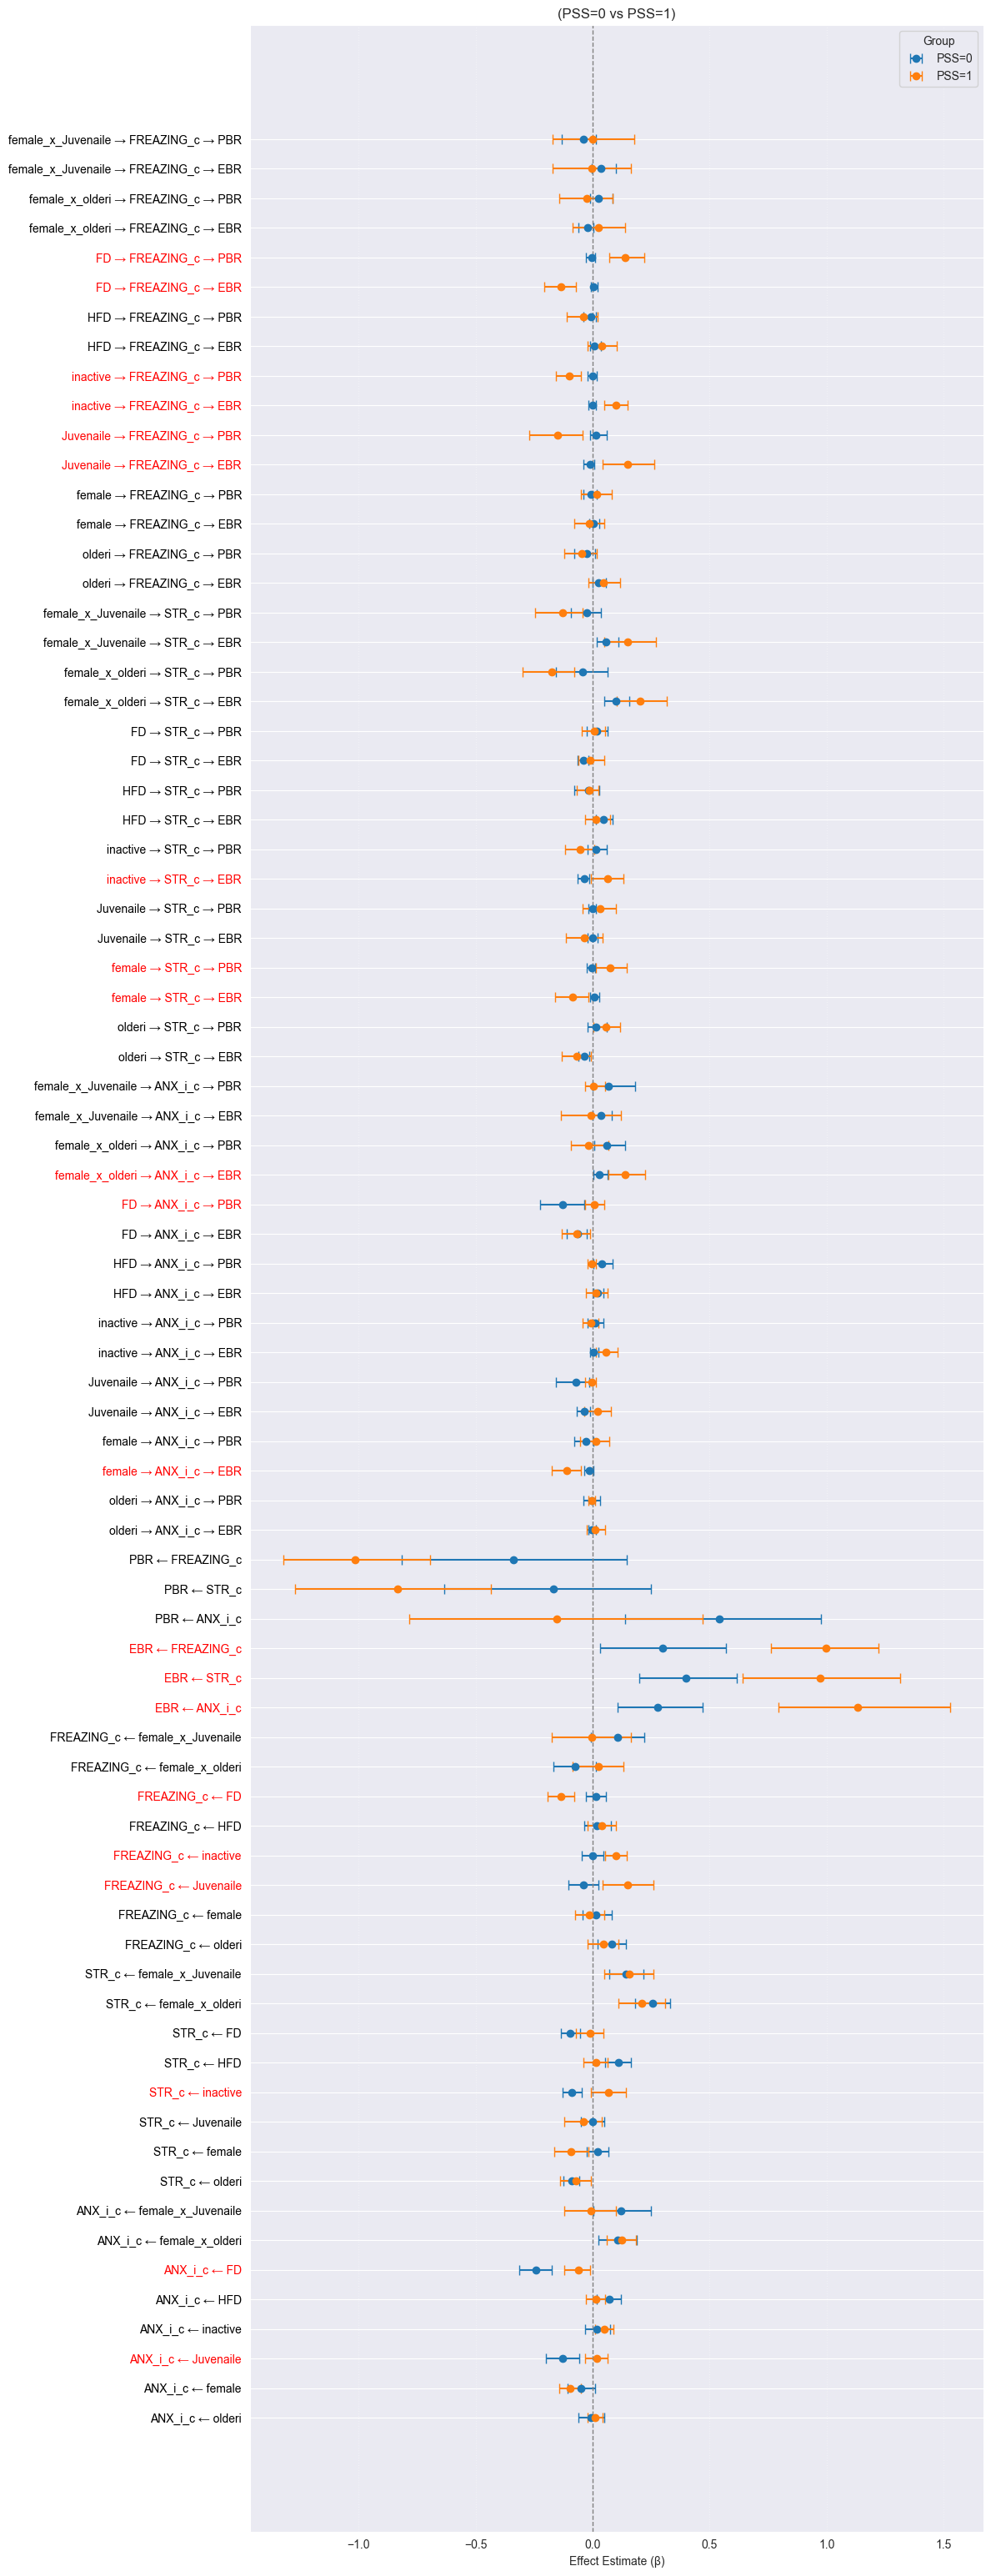

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# הכנה: יצירת טבלת long עם ציון האם יש חפיפה ב־CI
def prepare_plot_data(summary0, summary1):
    df0 = summary0.copy()
    df1 = summary1.copy()
    df0['Group'] = 'PSS=0'
    df1['Group'] = 'PSS=1'
    df0['Effect'] = df0.index
    df1['Effect'] = df1.index

    df0['CI_low'] = df0['CI_lo']
    df0['CI_high'] = df0['CI_hi']
    df1['CI_low'] = df1['CI_lo']
    df1['CI_high'] = df1['CI_hi']

    merged = df0.merge(df1, on='Effect', suffixes=('_0', '_1'))

    # האם יש חפיפה בין ה־CI?
    merged['Significant'] = ~(
        (merged['CI_high_0'] < merged['CI_low_1']) |
        (merged['CI_high_1'] < merged['CI_low_0'])
    )

    # הכנה לפורמט long
    long_rows = []
    for _, row in merged.iterrows():
        for g in ['0', '1']:
            long_rows.append({
                'Effect': row['Effect'],
                'Group': f'PSS={g}',
                'Estimate': row[f'Estimate_{g}'],
                'CI_low': row[f'CI_low_{g}'],
                'CI_high': row[f'CI_high_{g}'],
                'Significant': not row['Significant']  # True אם הבדל מובהק
            })

    return pd.DataFrame(long_rows)

# ✨ הפעל את הפונקציה על הטבלאות שלך
plot_df = prepare_plot_data(full_summary_pss0, full_summary_pss1)

# ציור
plt.figure(figsize=(12, int(len(plot_df['Effect'].unique()) * 0.4)))

# ציור error bars
for group in ['PSS=0', 'PSS=1']:
    subset = plot_df[plot_df['Group'] == group]
    plt.errorbar(
        subset['Estimate'],
        subset['Effect'],
        xerr=[subset['Estimate'] - subset['CI_low'], subset['CI_high'] - subset['Estimate']],
        fmt='o', label=group, capsize=4)

# הגדרת צבעים לפי מובהקות
effect_labels = []
label_colors = []
for effect in plot_df['Effect'].unique():
    is_significant = plot_df[plot_df['Effect'] == effect]['Significant'].any()
    effect_labels.append(effect)
    label_colors.append('red' if is_significant else 'black')

# עיצוב
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Effect Estimate (β)")
plt.yticks(ticks=range(len(effect_labels)), labels=effect_labels, color='black')
ax = plt.gca()
for label, color in zip(ax.get_yticklabels(), label_colors):
    label.set_color(color)

plt.title("(PSS=0 vs PSS=1)")
plt.legend(title="Group")
plt.tight_layout()
plt.grid(True, axis='x', linestyle=':', alpha=0.4)
plt.show()

## ריצה על מודל מאוחד עם אינטרקציות במקום מודלים מפוצלים


New Variance Inflation Factors (VIF):
                    Variable        VIF
0                    ANX_i_c   2.785492
1                      STR_c   2.232922
2                 FREAZING_c   2.187655
3                     olderi   5.459303
4                     female   5.844893
5                  Juvenaile   4.770254
6                        PSS   9.367670
7                   inactive   2.836488
8                        HFD   3.070397
9                         FD   3.537253
10                       EBR   3.951821
11                       PBR   2.007993
12        female_x_Juvenaile   5.746077
13           female_x_olderi   7.313214
14              PSS_x_olderi   5.773947
15              PSS_x_female   6.935545
16           PSS_x_Juvenaile   5.187456
17            PSS_x_inactive  14.242673
18                 PSS_x_HFD   3.258974
19                  PSS_x_FD   3.546667
20  PSS_x_female_x_Juvenaile   5.799497
21     PSS_x_female_x_olderi   6.881111


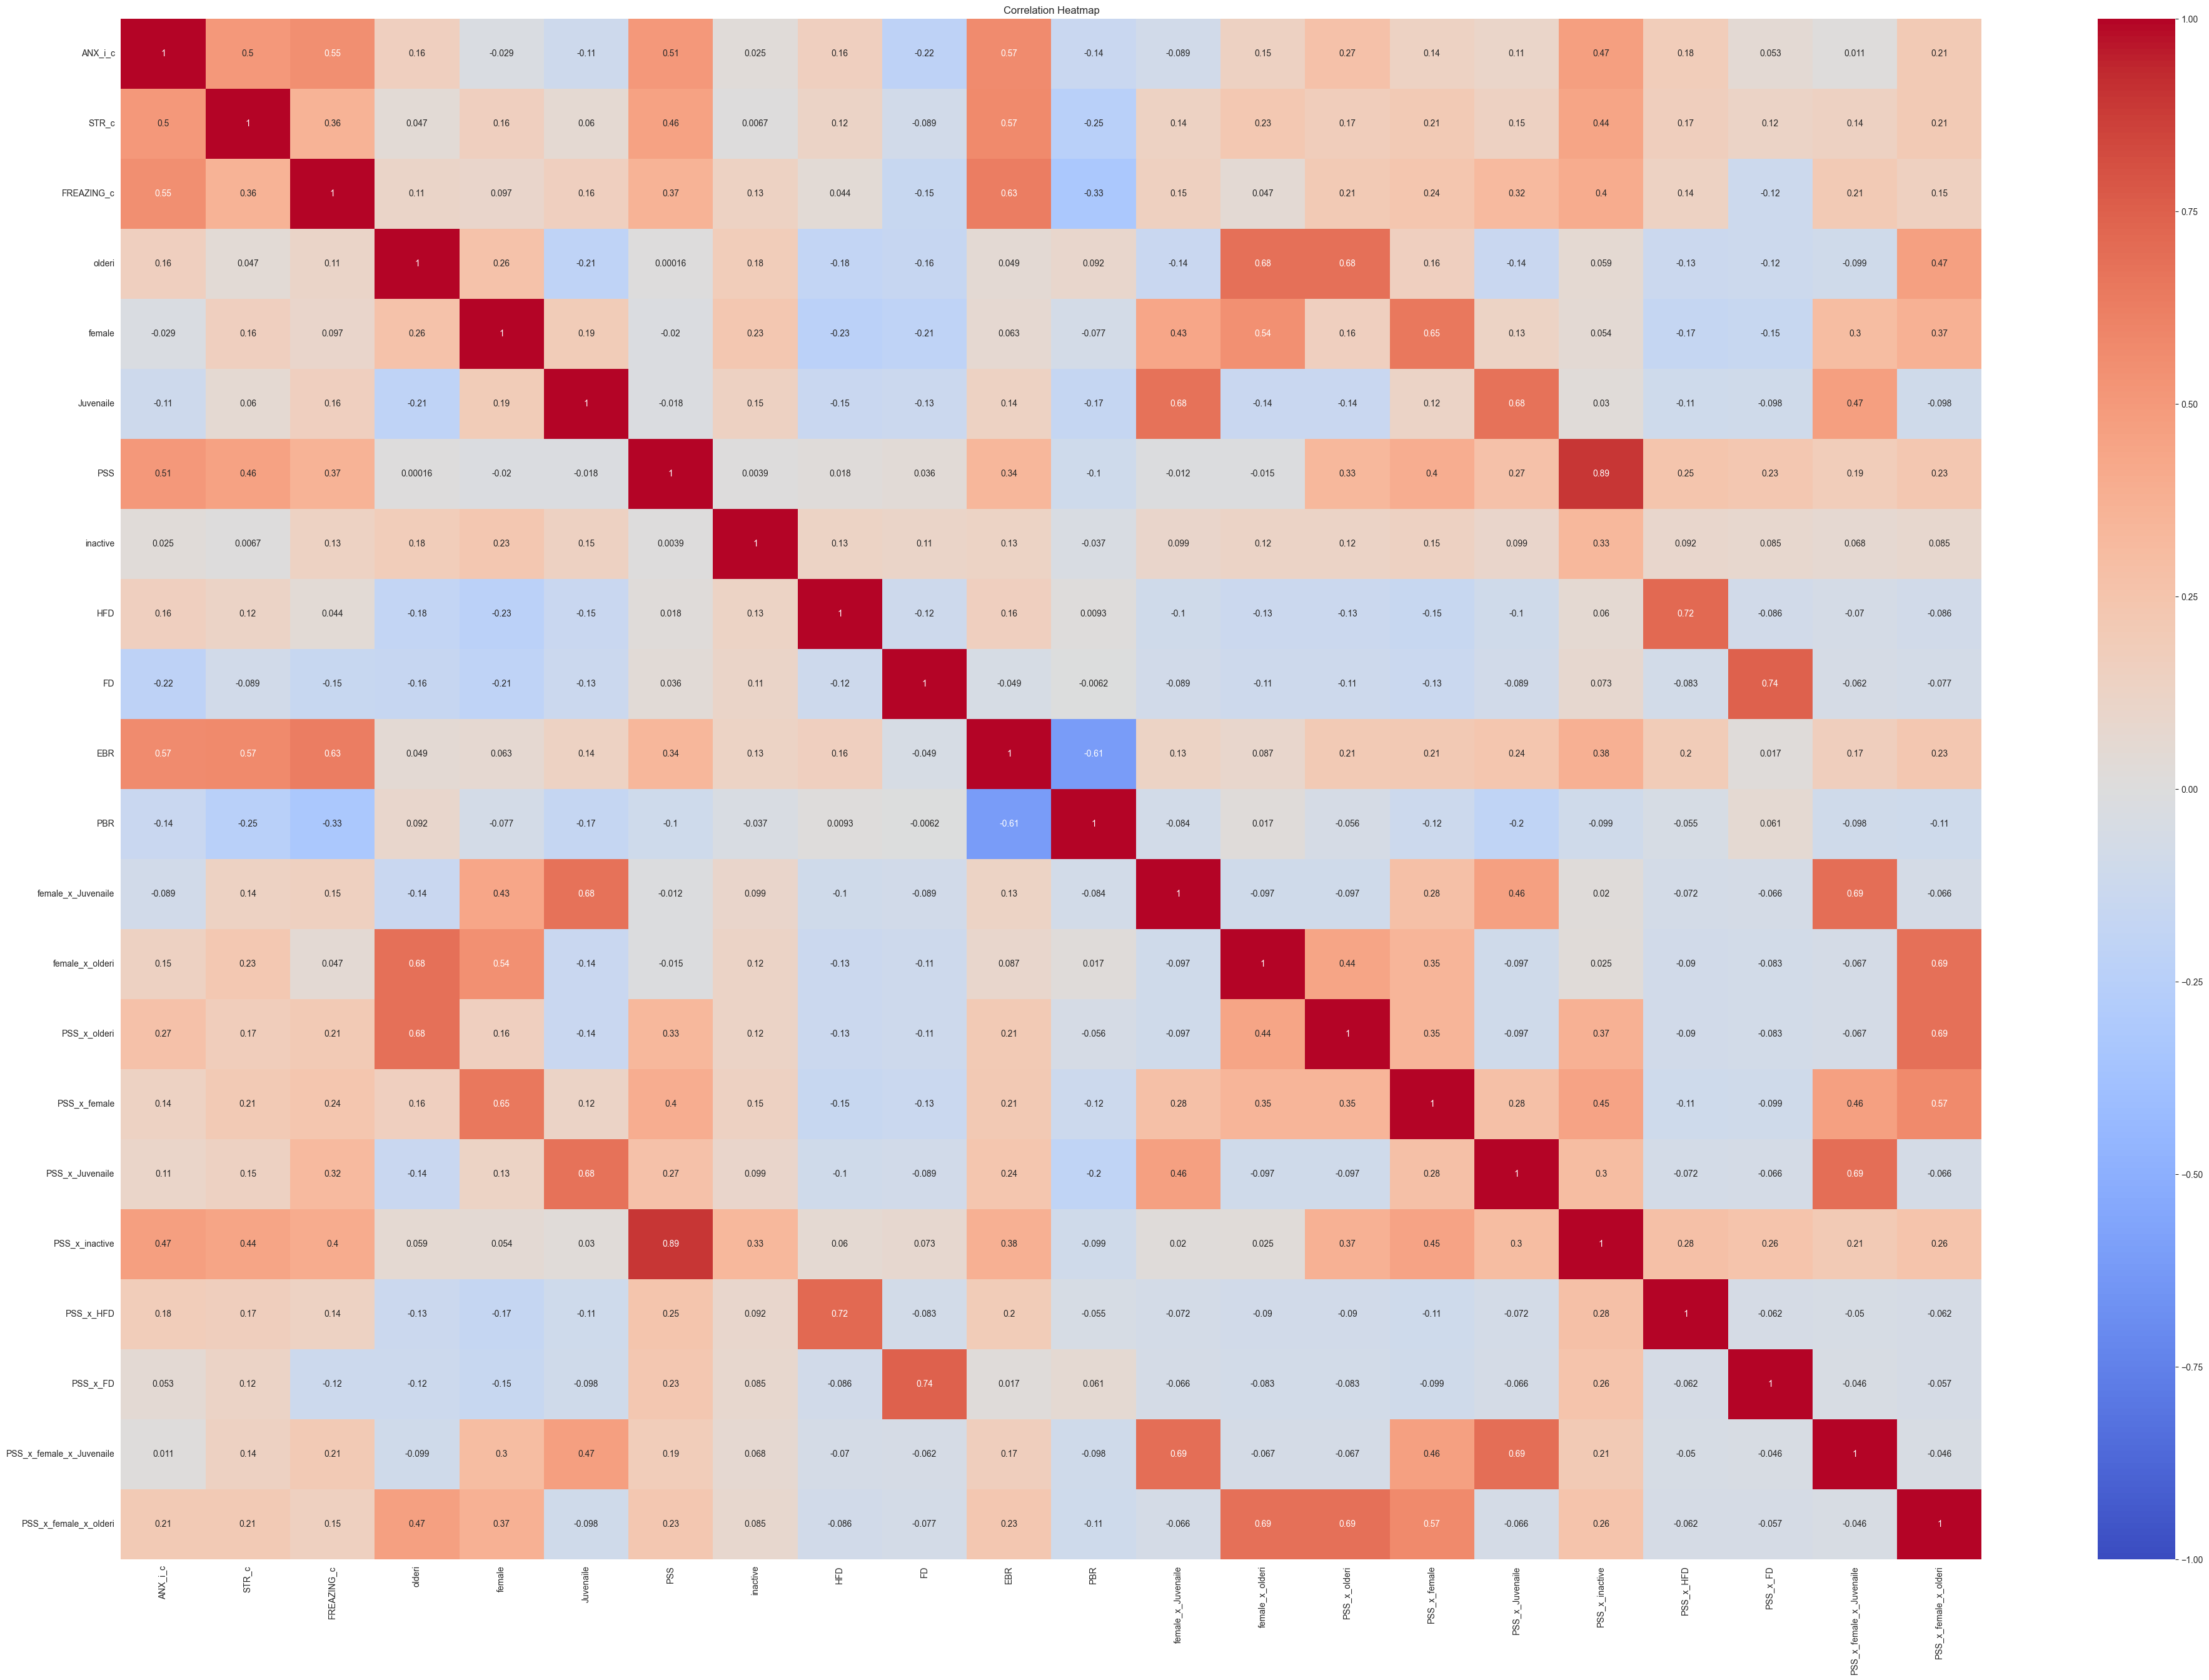


Detailed Correlation Matrix:
                            X                         Y   method alternative  \
0                     ANX_i_c                     STR_c  pearson   two-sided   
1                     ANX_i_c                FREAZING_c  pearson   two-sided   
2                     ANX_i_c                    olderi  pearson   two-sided   
3                     ANX_i_c                    female  pearson   two-sided   
4                     ANX_i_c                 Juvenaile  pearson   two-sided   
..                        ...                       ...      ...         ...   
226                 PSS_x_HFD  PSS_x_female_x_Juvenaile  pearson   two-sided   
227                 PSS_x_HFD     PSS_x_female_x_olderi  pearson   two-sided   
228                  PSS_x_FD  PSS_x_female_x_Juvenaile  pearson   two-sided   
229                  PSS_x_FD     PSS_x_female_x_olderi  pearson   two-sided   
230  PSS_x_female_x_Juvenaile     PSS_x_female_x_olderi  pearson   two-sided   

       n 

In [27]:

# 1. PSS INTERACTIONS
df['PSS_x_olderi']    = df['PSS'] * df['olderi']
df['PSS_x_female']    = df['PSS'] * df['female']
df['PSS_x_Juvenaile']    = df['PSS'] * df['Juvenaile']
df['PSS_x_inactive']    = df['PSS'] * df['inactive']
df['PSS_x_HFD']    = df['PSS'] * df['HFD']
df['PSS_x_FD']    = df['PSS'] * df['FD']
df['PSS_x_female_x_Juvenaile']    = df['PSS'] * df['female_x_Juvenaile']
df['PSS_x_female_x_olderi']    = df['PSS'] * df['female_x_olderi']

# חישוב VIF מחדש אחרי הוספה
X = df.assign(const=1)

vif_data = pd.DataFrame({
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# מסנן החוצה את הקבוע מהתצוגה
vif_data = vif_data[vif_data['Variable'] != 'const']

print("\nNew Variance Inflation Factors (VIF):")
print(vif_data)

# 8. מטריצת קורלציות (שוב)

# חישוב מטריצת קורלציות עם pingouin
corr = pg.pairwise_corr(df, method='pearson')

# הצגת מטריצת חום של הקורלציות
plt.figure(figsize=(48, 32))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

# הדפסת מטריצת הקורלציות המפורטת
print("\nDetailed Correlation Matrix:")
print(corr)

In [28]:

# =====================================================================
# 3. תיאור מודל SEM
model_desc = """
ANX_i_c      ~ olderi + female + Juvenaile + inactive + HFD + FD + female_x_olderi + female_x_Juvenaile + PSS + PSS_x_olderi + PSS_x_female + PSS_x_Juvenaile + PSS_x_inactive + PSS_x_HFD + PSS_x_FD + PSS_x_female_x_Juvenaile + PSS_x_female_x_olderi
STR_c        ~ olderi + female + Juvenaile + inactive + HFD + FD + female_x_olderi + female_x_Juvenaile + PSS + PSS_x_olderi + PSS_x_female + PSS_x_Juvenaile + PSS_x_inactive + PSS_x_HFD + PSS_x_FD + PSS_x_female_x_Juvenaile + PSS_x_female_x_olderi
FREAZING_c   ~ olderi + female + Juvenaile + inactive + HFD + FD + female_x_olderi + female_x_Juvenaile + PSS + PSS_x_olderi + PSS_x_female + PSS_x_Juvenaile + PSS_x_inactive + PSS_x_HFD + PSS_x_FD + PSS_x_female_x_Juvenaile + PSS_x_female_x_olderi

EBR          ~ ANX_i_c + STR_c + FREAZING_c
PBR          ~ ANX_i_c + STR_c + FREAZING_c

ANX_i_c ~~ STR_c
ANX_i_c ~~ FREAZING_c
STR_c   ~~ FREAZING_c
"""

# 6. ריצה
model, stats = fit_sem(df)

# 7. השוואת מדדי התאמה עם המפתחות הנכונים
fit_df = pd.DataFrame({
    'Chi2':stats['chi2'],'DoF':stats['DoF'],'CFI':stats['CFI'],'RMSEA':stats['RMSEA'],'AIC':stats['AIC'],'BIC':stats['BIC']})

print("\nSEM Fit Comparison PSS_INT:")
print(fit_df.to_string())

# 8. (אופציונלי) הצגת אומדני פרמטרים
print("\nParameter Estimates PSS_INT:")
print(model.inspect().to_string())


SEM Fit Comparison PSS_INT:
             Chi2  DoF       CFI     RMSEA         AIC         BIC
Value  385.772871  188  0.978265  0.043537  128.612328  409.462267

Parameter Estimates PSS_INT:
          lval  op                      rval  Estimate  Std. Err    z-value       p-value
0      ANX_i_c   ~                    olderi -0.007131  0.027982  -0.254835  7.988502e-01
1      ANX_i_c   ~                    female -0.047294  0.026285  -1.799302  7.197087e-02
2      ANX_i_c   ~                 Juvenaile -0.128245  0.030351  -4.225402  2.385151e-05
3      ANX_i_c   ~                  inactive  0.019601  0.026285   0.745703  4.558470e-01
4      ANX_i_c   ~                       HFD  0.071076  0.026585   2.673507  7.506278e-03
5      ANX_i_c   ~                        FD -0.241662  0.029298  -8.248377  2.220446e-16
6      ANX_i_c   ~           female_x_olderi  0.106169  0.041282   2.571810  1.011685e-02
7      ANX_i_c   ~        female_x_Juvenaile  0.121282  0.045527   2.663987  7.722047e-

In [29]:


# ---------- 4. הפעלה ----------
boot_df, full_summary = bootstrap_sem(model_desc,df, n_boot=2000)

# --- נתיבים ישירים ---
direct_summary = full_summary[full_summary.index.str.contains("←")]

#     טבלת תיווכים בלבד
indirect_summary = full_summary[full_summary.index.str.contains("→")]

print("\nאפקטים ישירים – Bootstrap PSS_1:")
print(direct_summary.round(3).to_string())

print("\nאפקטים עקיפים (תיווך) – Bootstrap PSS_1:")
print(indirect_summary.round(3).to_string())



אפקטים ישירים – Bootstrap PSS_1:
                                       Estimate     SE  CI_lo  CI_hi   CI_w       Z  p_boot  Sig (p<.05)
ANX_i_c ← olderi                         -0.007  0.028 -0.063  0.048  0.110  -0.268   0.799        False
ANX_i_c ← female                         -0.047  0.030 -0.105  0.013  0.118  -1.578   0.114        False
ANX_i_c ← Juvenaile                      -0.128  0.036 -0.202 -0.057  0.145  -3.561   0.000         True
ANX_i_c ← inactive                        0.019  0.027 -0.033  0.073  0.106   0.708   0.464        False
ANX_i_c ← HFD                             0.071  0.029  0.015  0.125  0.111   2.492   0.012         True
ANX_i_c ← FD                             -0.242  0.036 -0.313 -0.172  0.141  -6.807   0.000         True
ANX_i_c ← female_x_olderi                 0.107  0.041  0.028  0.183  0.155   2.616   0.008         True
ANX_i_c ← female_x_Juvenaile              0.121  0.059  0.008  0.242  0.234   2.033   0.031         True
ANX_i_c ← PSS        

SEM diagram for PSS saved as sem_diagram_pss_INT.png


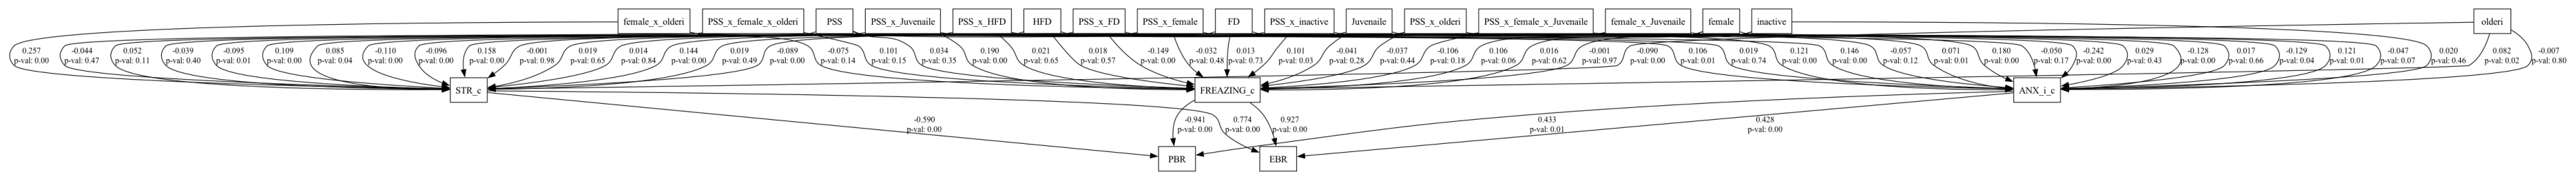

In [30]:

# הפקת דיאגרמת SEM עבור PSS
semplot(model, "sem_diagram_pss_INT.png")
print("SEM diagram for PSS saved as sem_diagram_pss_INT.png")
plt.figure(figsize=(48, 32))  # קובע את גודל החלון
plt.imshow(plt.imread("sem_diagram_pss_INT.png"))
plt.axis('off')  # להסתיר את הצירים
plt.show()

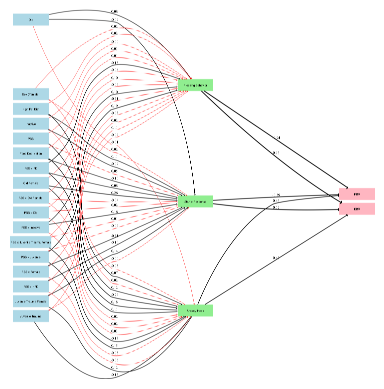

In [31]:

# יצירת גרף
dot = Digraph(comment='SEM Diagram', format='png', engine='dot')

# התאמות כלליות
dot.attr(rankdir='LR', dpi='150', splines='true', nodesep='1', ranksep='40')

# עיצוב ברירת מחדל
dot.attr('node', shape='box', style='filled', fontsize='70', fontname='David', width='12', height='4')

# ------------------
# מיפוי שמות מקוריים -> שמות מוצגים
node_labels = {
    'olderi': 'Old',
    'female': 'Sex (Female)',
    'Juvenaile': 'Juvenile Trauma',
    'inactive': 'Inactive',
    'HFD': 'High Fat Diet',
    'FD': 'Food Deprivation',
    'female_x_olderi': 'Old Female',
    'female_x_Juvenaile': 'Juvenile Trauma Female',
    'PSS': 'PSS',
    'PSS_x_olderi': 'PSS × Old',
    'PSS_x_female': 'PSS × Female',
    'PSS_x_Juvenaile': 'PSS × Juvenile',
    'PSS_x_inactive': 'PSS × Inactive',
    'PSS_x_HFD': 'PSS × HFD',
    'PSS_x_FD': 'PSS × FD',
    'PSS_x_female_x_Juvenaile': 'PSS × Juvenile Trauma Female',
    'PSS_x_female_x_olderi': 'PSS × Old Female ',
    'ANX_i_c': 'Anxiety Index',
    'STR_c': 'Startle Response',
    'FREAZING_c': 'Freezing Behavior',
    'EBR': 'EBR',
    'PBR': 'PBR'
}

# ------------------
# משתנים לפי קבוצות
background_vars = [
    'olderi', 'female', 'Juvenaile', 'inactive', 'HFD', 'FD',
    'female_x_olderi', 'female_x_Juvenaile',
    'PSS', 'PSS_x_olderi', 'PSS_x_female', 'PSS_x_Juvenaile',
    'PSS_x_inactive', 'PSS_x_HFD', 'PSS_x_FD',
    'PSS_x_female_x_Juvenaile', 'PSS_x_female_x_olderi'
]
mediators = ['ANX_i_c', 'STR_c', 'FREAZING_c']
outcomes = ['EBR', 'PBR']

# ------------------
# פונקציה אוטומטית לסידור בקבוצות
def add_nodes_in_group(dot, nodes, color):
    with dot.subgraph() as s:
        s.attr(rank='same')
        for node in nodes:
            label = node_labels.get(node, node)
            s.node(node, label=label, color=color)

# סידור משתנים לפי קבוצה
add_nodes_in_group(dot, background_vars, 'lightblue')
add_nodes_in_group(dot, mediators, 'lightgreen')
add_nodes_in_group(dot, outcomes, 'lightpink')

def estimate_penwidth(beta):
    """
    מחשב את עובי הקו לפי ערך מוחלט של β
    """
    return 1 + abs(beta) * 10 +10  # קו בסיסי בעובי 1, ועולה עם חוזק האפקט

def estimate_style(beta, significance_threshold=0.05):
    """
    מחזיר סגנון קו: קו רציף אם האפקט מובהק, קו מקוקו אם לא
    """
    return 'solid' if abs(beta) < significance_threshold else 'dashed'

def estimate_color(beta, significance_threshold=0.05):
    """
    מחזיר סגנון קו: קו רציף אם האפקט מובהק, קו מקוקו אם לא
    """
    return 'black' if abs(beta) < significance_threshold else 'red'



# שליפת האומדנים
inspect_df = model.inspect()

# נשמור רק את הנתיבים (ולא שונויות, לא קווריאנסים וכו')
edges = inspect_df[inspect_df['op'] == '~'][['lval', 'rval', 'Estimate', 'p-value']]

# יצירת רשימת משתנים
variables = set(edges['lval']).union(set(edges['rval']))
for var in variables:
    dot.node(var.strip())

# הוספת חצים
for _, row in edges.iterrows():
    label = f"{row['Estimate']:.2f}"
    dot.edge(row['rval'].strip(), row['lval'].strip(), label=label,fontsize='90' , penwidth=str(estimate_penwidth(row['Estimate'])),  # עובי בהתאם לגודל β
                 style=estimate_style(row['p-value'] ), color =estimate_color(row['p-value'] ) )             # קו רציף או מקוקו)


# ------------------
# שמירה לקובץ
dot.render('sem_diagram_pss_INT_M')

plt.imshow(plt.imread("sem_diagram_pss_INT_M.png"))
plt.axis('off')  # להסתיר את הצירים
plt.show()

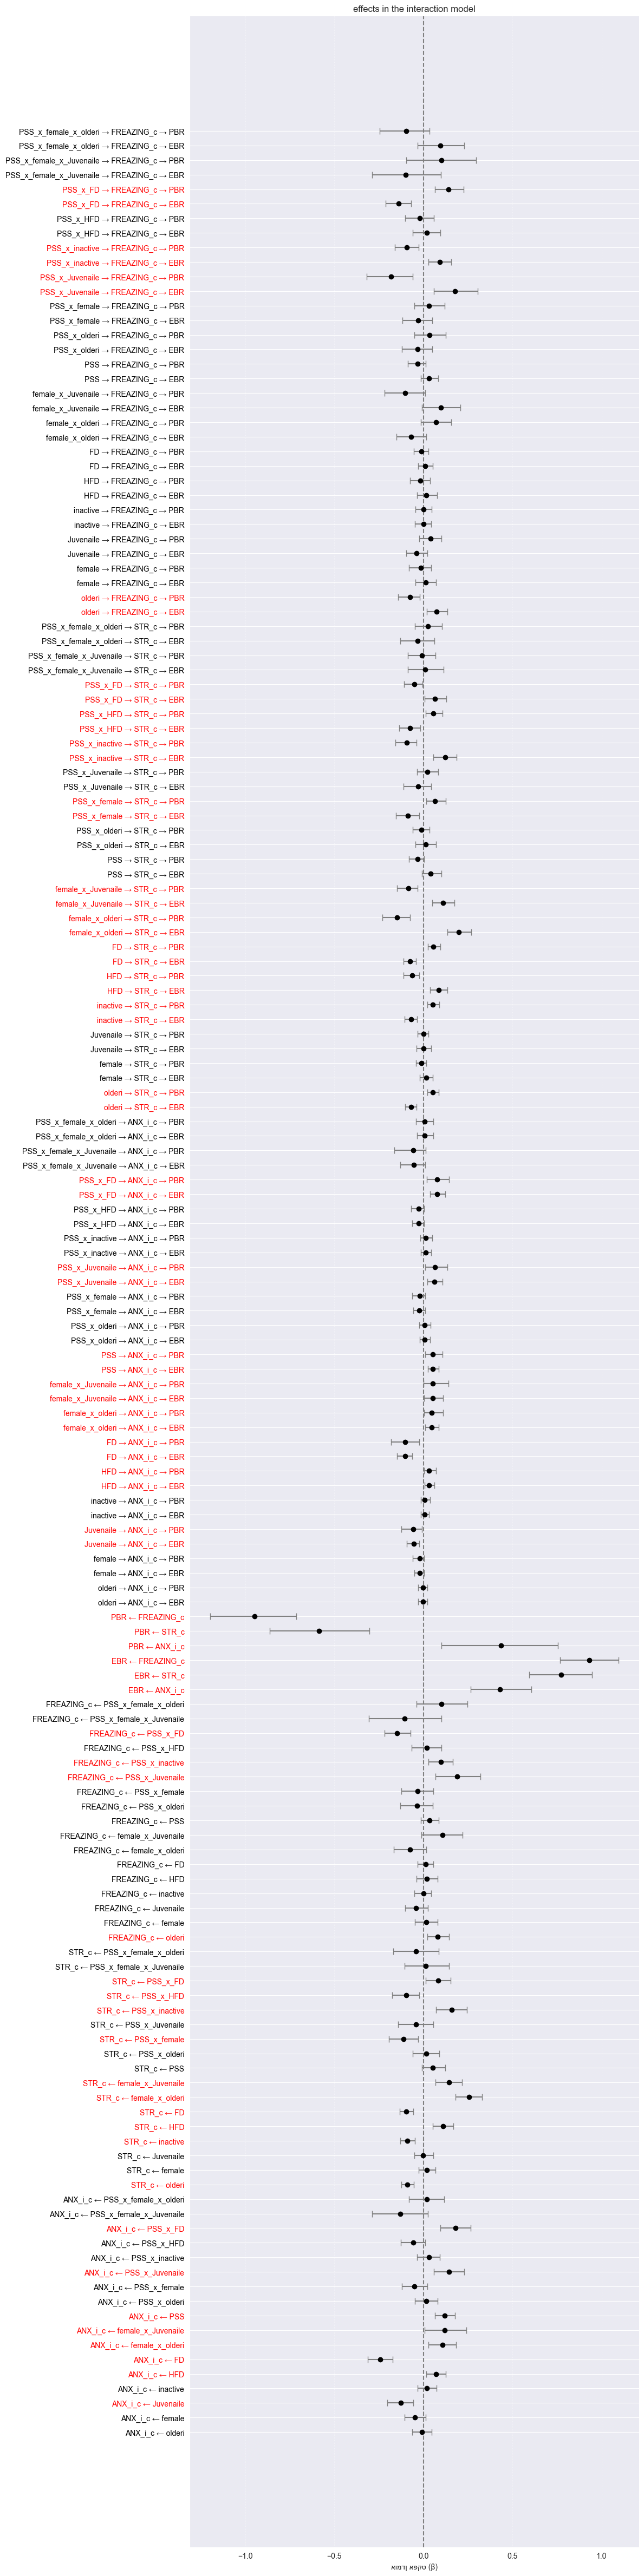

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

# איחוד כל האפקטים (ישירים + עקיפים)
all_effects = pd.concat([direct_summary, indirect_summary])
all_effects = all_effects.reset_index().rename(columns={'index': 'Effect'})

# סימון צבע לפי מובהקות
all_effects['color'] = all_effects['Sig (p<.05)'].apply(lambda x: 'red' if x else 'black')

# ציור גרף
plt.figure(figsize=(12, len(all_effects) * 0.3))
plt.errorbar(
    all_effects['Estimate'],
    all_effects['Effect'],
    xerr=[
        all_effects['Estimate'] - all_effects['CI_lo'],
        all_effects['CI_hi'] - all_effects['Estimate']
    ],
    fmt='o',
    ecolor='gray',
    capsize=4,
    color='black'
)

# צביעת שמות האפקטים
ax = plt.gca()
ax.set_yticks(range(len(all_effects)))
ax.set_yticklabels(all_effects['Effect'], color='black')
for label, color in zip(ax.get_yticklabels(), all_effects['color']):
    label.set_color(color)

plt.axvline(x=0, color='gray', linestyle='--')
plt.xlabel("אומדן אפקט (β)")
plt.title("effects in the interaction model")
plt.tight_layout()
plt.grid(True, axis='x', linestyle=':', alpha=0.5)
plt.show()

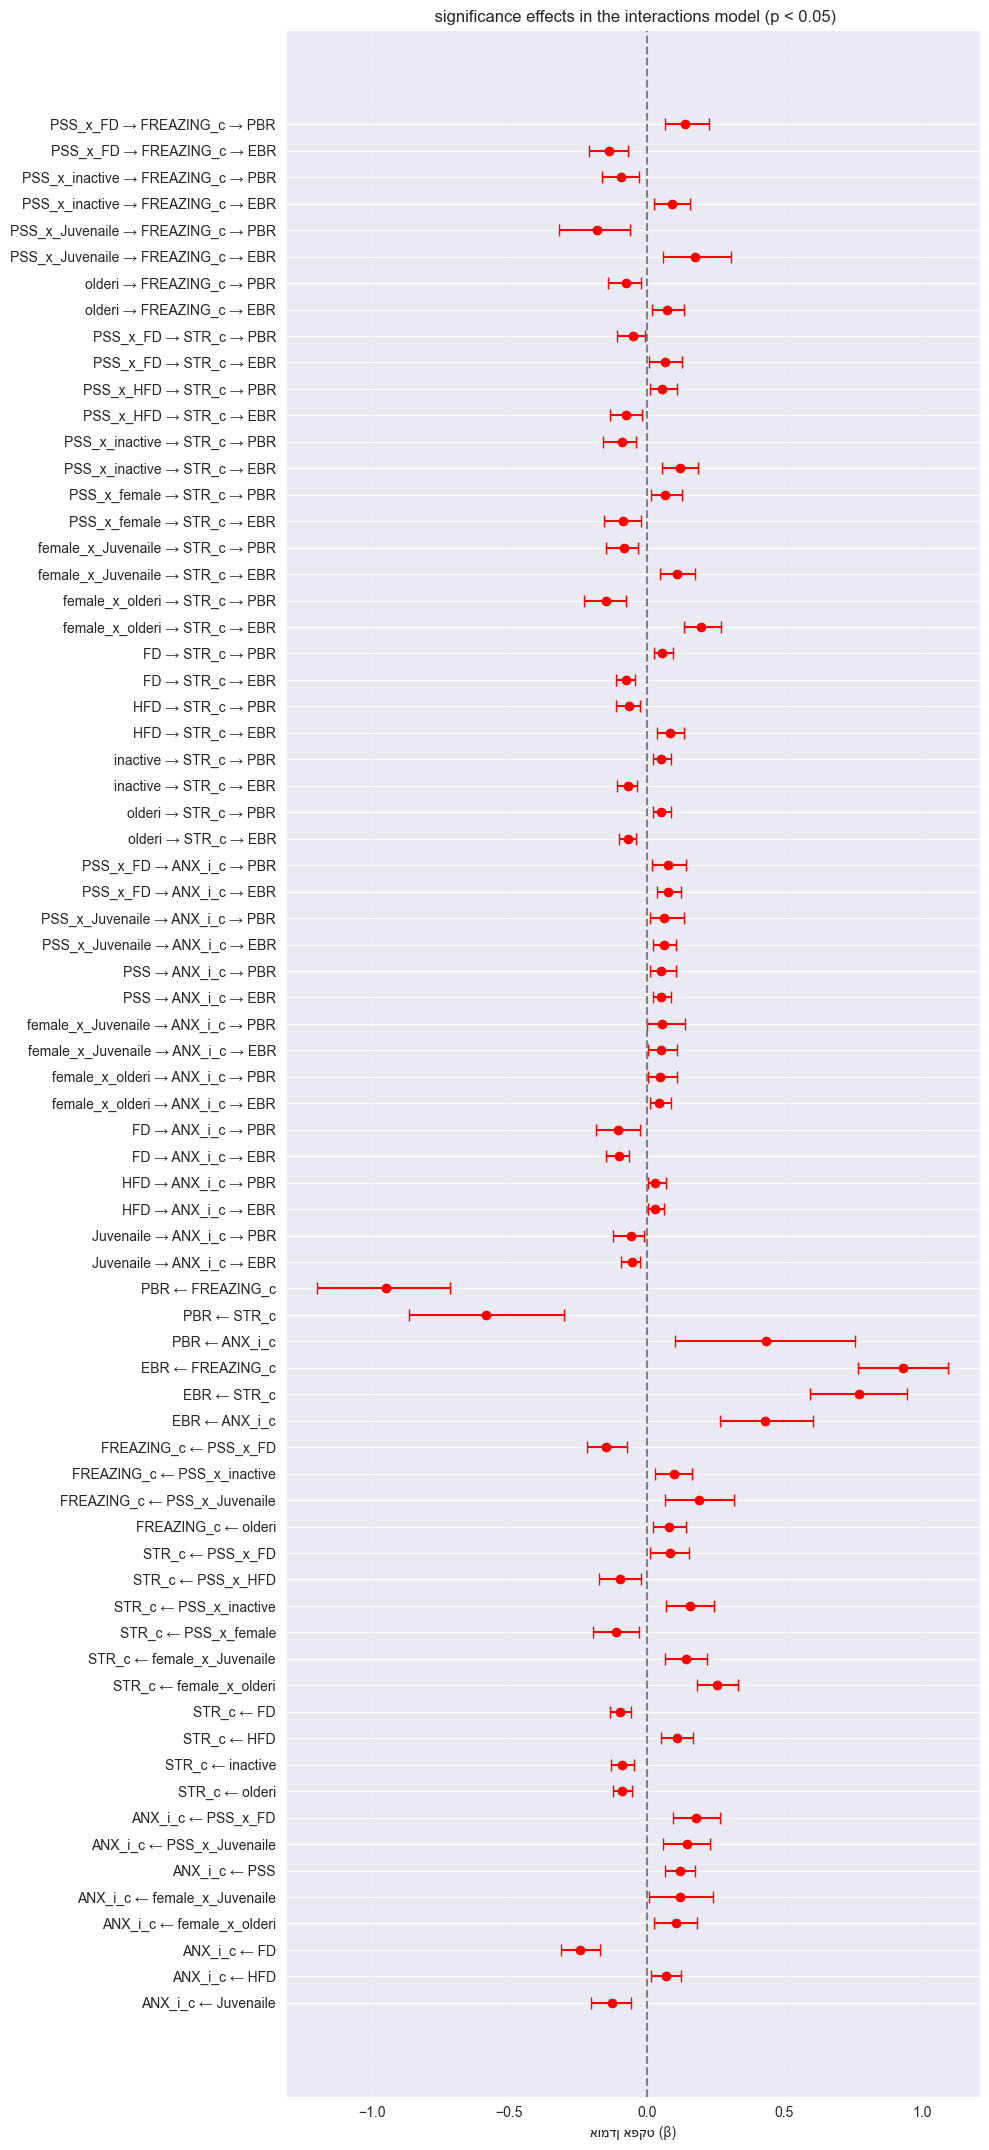

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# מיזוג ישירים ועקיפים
all_effects = pd.concat([direct_summary, indirect_summary])
all_effects = all_effects.reset_index().rename(columns={'index': 'Effect'})

# סינון לאפקטים מובהקים בלבד
sig_effects = all_effects[all_effects['Sig (p<.05)'] == True]

# ציור גרף
plt.figure(figsize=(10, len(sig_effects) * 0.3))
plt.errorbar(
    sig_effects['Estimate'],
    sig_effects['Effect'],
    xerr=[
        sig_effects['Estimate'] - sig_effects['CI_lo'],
        sig_effects['CI_hi'] - sig_effects['Estimate']
    ],
    fmt='o',
    ecolor='red',
    capsize=4,
    color='red'
)

plt.axvline(x=0, color='gray', linestyle='--')
plt.xlabel("אומדן אפקט (β)")
plt.title(" significance effects in the interactions model (p < 0.05)")
plt.tight_layout()
plt.grid(True, axis='x', linestyle=':', alpha=0.5)
plt.show()

# XGboost

                  Scenario  EBR_prob_mean  PBR_prob_mean  MBR_prob_mean
0        Olderi Male PSS=1          0.268          0.584          0.148
1        Olderi Male PSS=0          0.001          0.738          0.261
2     Juvenaile Male PSS=1          0.368          0.130          0.501
3     Juvenaile Male PSS=0          0.010          0.449          0.542
4      Olderi Female PSS=1          0.325          0.337          0.338
5      Olderi Female PSS=0          0.003          0.775          0.222
6   Juvenaile Female PSS=1          0.374          0.257          0.369
7   Juvenaile Female PSS=0          0.466          0.477          0.057
8       Young female PSS=1          0.246          0.474          0.280
9       Young female PSS=0          0.003          0.380          0.617
10  Sleep-time Event PSS=1          0.562          0.628         -0.190
11  Sleep-time Event PSS=0          0.001          0.303          0.696
12             Obese PSS=1          0.323          0.397        

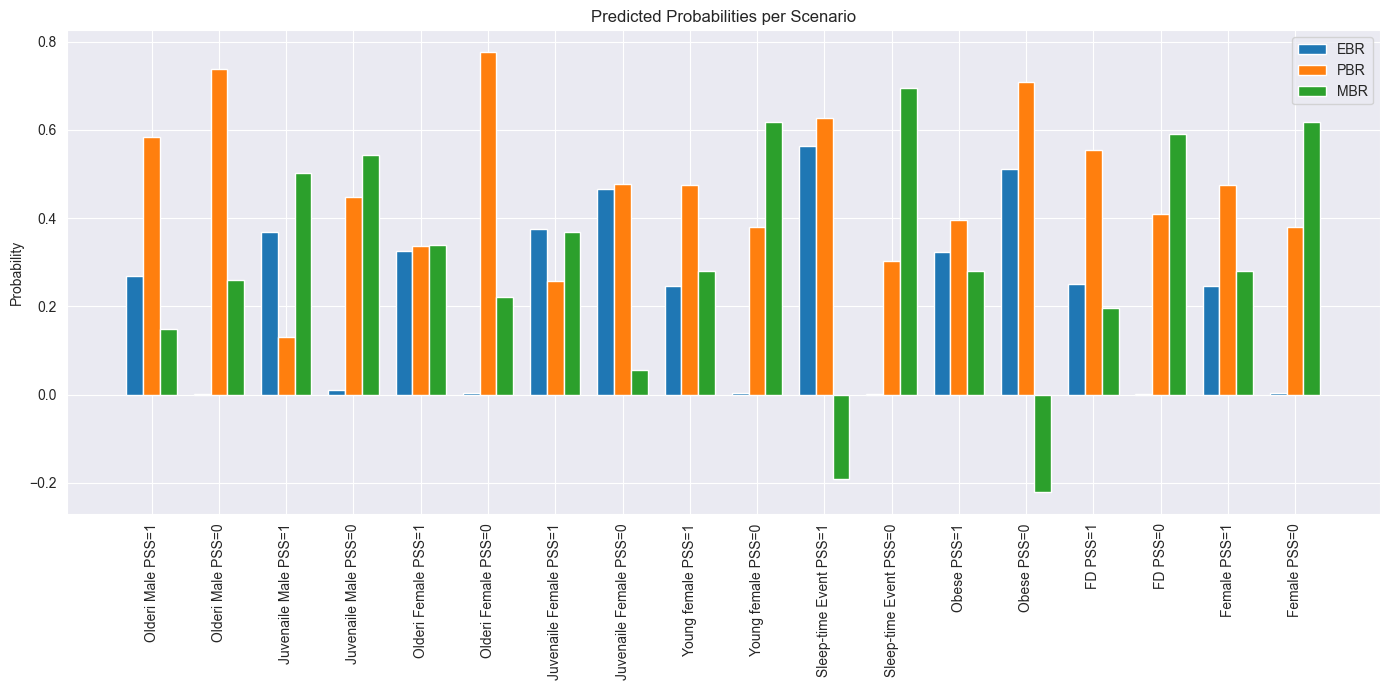

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from xgboost import XGBClassifier

# Load data
df = pd.read_csv("df.csv")

# Features
all_features = ['olderi', 'female', 'Juvenaile', 'PSS', 'inactive', 'HFD', 'FD',
                'ANX_i_c', 'STR_c', 'FREAZING_c']
prediction_features = ['olderi', 'female', 'Juvenaile', 'PSS', 'inactive', 'HFD', 'FD']

# Scenario names
scenario_names = [
    "Olderi Male PSS=1",
    "Olderi Male PSS=0",
    "Juvenaile Male PSS=1",
    "Juvenaile Male PSS=0",
    "Olderi Female PSS=1",
    "Olderi Female PSS=0",
    "Juvenaile Female PSS=1",
    "Juvenaile Female PSS=0",
    "Young female PSS=1",
    "Young female PSS=0",
    "Sleep-time Event PSS=1",
    "Sleep-time Event PSS=0",
    "Obese PSS=1",
    "Obese PSS=0",
    "FD PSS=1",
    "FD PSS=0",
    "Female PSS=1",
    "Female PSS=0",
]

# Scenario inputs
scenarios = pd.DataFrame([
    [1, 0, 0, 1, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 1],
    [0, 0, 1, 1, 0, 0, 1],
    [0, 0, 1, 0, 0, 0, 1],
    [1, 1, 0, 1, 0, 0, 1],
    [1, 1, 0, 0, 0, 0, 1],
    [0, 1, 1, 1, 0, 0, 1],
    [0, 1, 1, 0, 0, 0, 1],
    [0, 1, 0, 1, 0, 0, 1],
    [0, 1, 0, 0, 0, 0, 1],
    [0, 0, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 1, 0, 1],
    [0, 0, 0, 1, 0, 1, 0],
    [0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 1, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 1],
    [0, 1, 0, 1, 0, 0, 1],
    [0, 1, 0, 0, 0, 0, 1],
], columns=prediction_features)

# Bootstrap
n_iterations = 30
ebr_all = []
pbr_all = []

for i in range(n_iterations):
    boot_df = resample(df, replace=True, n_samples=len(df))
    X_train = boot_df[all_features]
    y_ebr = boot_df['EBR']
    y_pbr = boot_df['PBR']

    ebr_weight = (y_ebr == 0).sum() / max((y_ebr == 1).sum(), 1)
    pbr_weight = (y_pbr == 0).sum() / max((y_pbr == 1).sum(), 1)

    model_ebr = XGBClassifier(
        eval_metric='logloss',
        scale_pos_weight=ebr_weight,
        n_jobs=-1,
        random_state=42 + i
    )
    model_pbr = XGBClassifier(
        eval_metric='logloss',
        scale_pos_weight=pbr_weight,
        n_jobs=-1,
        random_state=42 + i
    )

    model_ebr.fit(X_train[prediction_features], y_ebr)
    model_pbr.fit(X_train[prediction_features], y_pbr)

    ebr_all.append(model_ebr.predict_proba(scenarios)[:, 1])
    pbr_all.append(model_pbr.predict_proba(scenarios)[:, 1])

# Calculate results
ebr_all = np.array(ebr_all)
pbr_all = np.array(pbr_all)

ebr_mean = ebr_all.mean(axis=0)
pbr_mean = pbr_all.mean(axis=0)
mbr_mean = 1 - (ebr_mean + pbr_mean)

# Final dataframe
summary = pd.DataFrame({
    "Scenario": scenario_names,
    "EBR_prob_mean": ebr_mean,
    "PBR_prob_mean": pbr_mean,
    "MBR_prob_mean": mbr_mean
})

# Print table
pd.set_option('display.float_format', lambda x: f'{x:.3f}')
print(summary)

# Optional: Save to CSV
# summary.to_csv("scenario_probabilities.csv", index=False)

# Plot
fig, ax = plt.subplots(figsize=(14, 7))
x = np.arange(len(scenario_names))
bar_width = 0.25

ax.bar(x - bar_width, summary["EBR_prob_mean"], width=bar_width, label="EBR")
ax.bar(x, summary["PBR_prob_mean"], width=bar_width, label="PBR")
ax.bar(x + bar_width, summary["MBR_prob_mean"], width=bar_width, label="MBR")

ax.set_xticks(x)
ax.set_xticklabels(scenario_names, rotation=90)
ax.set_ylabel("Probability")
ax.set_title("Predicted Probabilities per Scenario")
ax.legend()
plt.tight_layout()
plt.show()

                  Scenario  EBR_prob_mean  EBR_prob_std  PBR_prob_mean  \
0        Olderi Male PSS=1          0.095         0.090          0.785   
1        Olderi Male PSS=0          0.001         0.001          0.873   
2     Juvenaile Male PSS=1          0.211         0.180          0.390   
3     Juvenaile Male PSS=0          0.006         0.003          0.582   
4      Olderi Female PSS=1          0.172         0.152          0.684   
5      Olderi Female PSS=0          0.002         0.001          0.837   
6   Juvenaile Female PSS=1          0.178         0.166          0.573   
7   Juvenaile Female PSS=0          0.130         0.073          0.591   
8       Young female PSS=1          0.060         0.041          0.695   
9       Young female PSS=0          0.003         0.001          0.518   
10  Sleep-time Event PSS=1          0.218         0.072          0.755   
11  Sleep-time Event PSS=0          0.001         0.000          0.470   
12             Obese PSS=1          0.

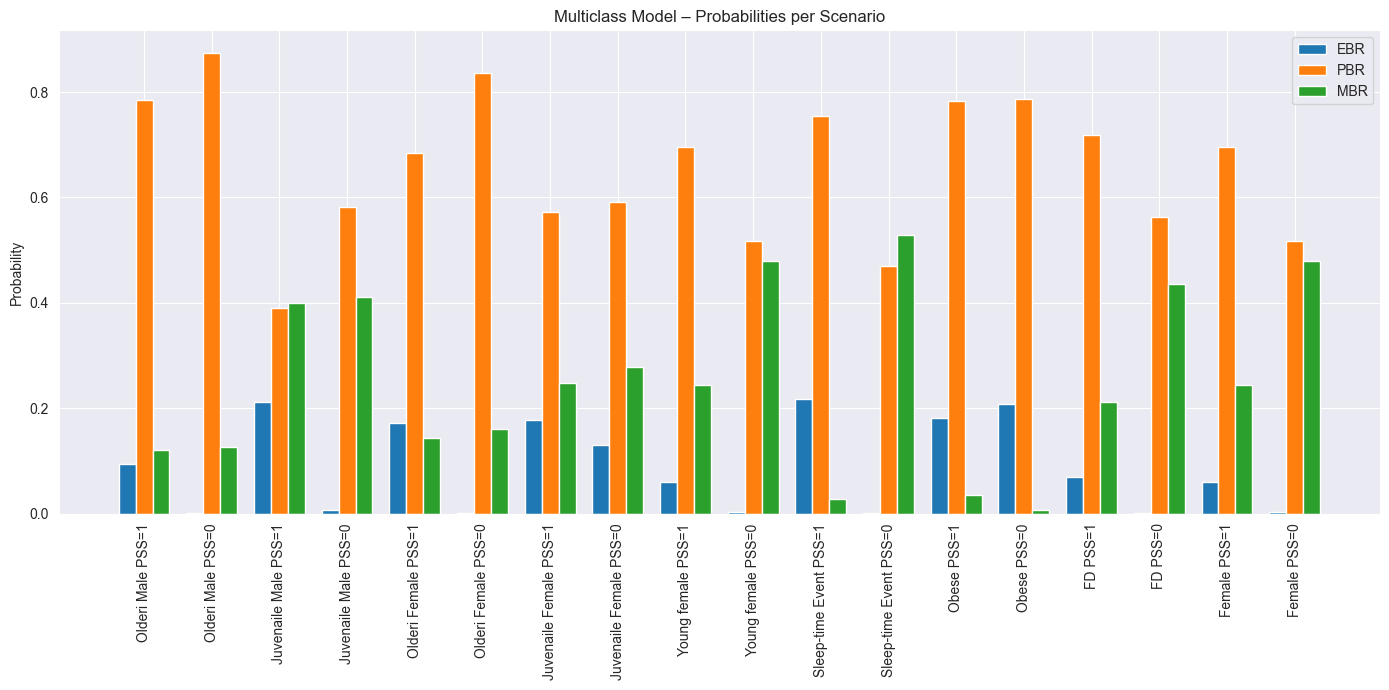

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from xgboost import XGBClassifier

# Load dataset
df = pd.read_csv("df.csv")

# Define multi-class target
def classify(row):
    if row['EBR'] == 1:
        return 1  # EBR
    elif row['PBR'] == 1:
        return 2  # PBR
    else:
        return 0  # MBR

df['Group'] = df.apply(classify, axis=1)

# Bootstrap
n_iterations = 30
mbr_all = []
ebr_all = []
pbr_all = []

for i in range(n_iterations):
    boot_df = resample(df, replace=True, n_samples=len(df))
    X_train = boot_df[all_features]
    y_train = boot_df['Group']

    model = XGBClassifier(
        objective='multi:softprob',
        num_class=3,
        eval_metric='mlogloss',
        n_jobs=-1,
        random_state=42 + i
    )
    model.fit(X_train[prediction_features], y_train)

    probs = model.predict_proba(scenarios)  # shape (n_scenarios, 3)
    mbr_all.append(probs[:, 0])
    ebr_all.append(probs[:, 1])
    pbr_all.append(probs[:, 2])

# Aggregate
ebr_mean = np.mean(ebr_all, axis=0)
pbr_mean = np.mean(pbr_all, axis=0)
mbr_mean = np.mean(mbr_all, axis=0)

ebr_std = np.std(ebr_all, axis=0)
pbr_std = np.std(pbr_all, axis=0)
mbr_std = np.std(mbr_all, axis=0)

summary = pd.DataFrame({
    "Scenario": scenario_names,
    "EBR_prob_mean": ebr_mean,
    "EBR_prob_std": ebr_std,
    "PBR_prob_mean": pbr_mean,
    "PBR_prob_std": pbr_std,
    "MBR_prob_mean": mbr_mean,
    "MBR_prob_std": mbr_std
})

# Print table
pd.set_option('display.float_format', lambda x: f'{x:.3f}')
print(summary)

# Optional: Save
# summary.to_csv("multiclass_predictions.csv", index=False)

# Plot
fig, ax = plt.subplots(figsize=(14, 7))
x = np.arange(len(scenario_names))
bar_width = 0.25

ax.bar(x - bar_width, summary["EBR_prob_mean"], width=bar_width, label="EBR")
ax.bar(x, summary["PBR_prob_mean"], width=bar_width, label="PBR")
ax.bar(x + bar_width, summary["MBR_prob_mean"], width=bar_width, label="MBR")

ax.set_xticks(x)
ax.set_xticklabels(scenario_names, rotation=90)
ax.set_ylabel("Probability")
ax.set_title("Multiclass Model – Probabilities per Scenario")
ax.legend()
plt.tight_layout()
plt.show()

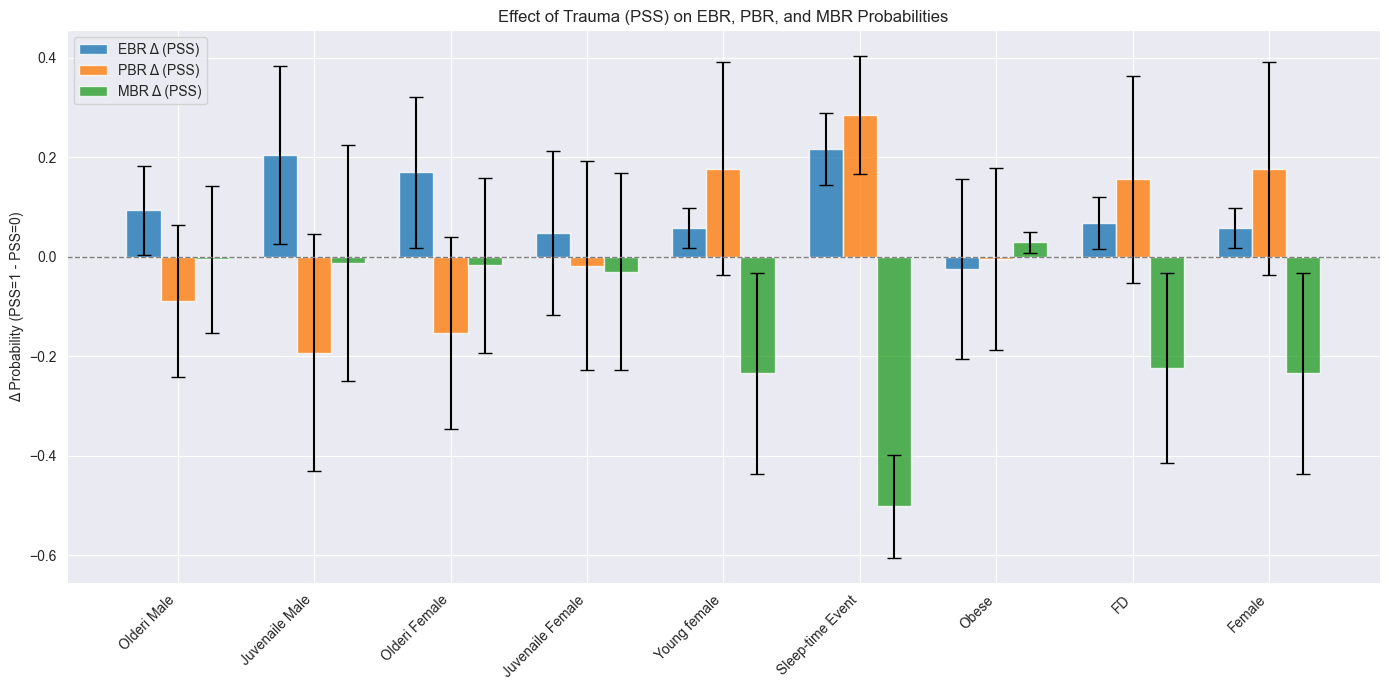

In [36]:
import numpy as np
import matplotlib.pyplot as plt



# Make sure ebr_all and pbr_all are NumPy arrays
ebr_all = np.array(ebr_all)
pbr_all = np.array(pbr_all)

# Group names (every pair is PSS=1 and PSS=0)
group_names = [
    "Olderi Male",
    "Juvenaile Male",
    "Olderi Female",
    "Juvenaile Female",
    "Young female",
    "Sleep-time Event",
    "Obese",
    "FD",
    "Female"
]

# Indices of PSS=1 and PSS=0 for each group
pss1_indices = list(range(0, 18, 2))  # even indices (0,2,4,...)
pss0_indices = list(range(1, 18, 2))  # odd indices (1,3,5,...)

# Compute bootstrap deltas for EBR, PBR, and MBR
ebr_deltas = []
pbr_deltas = []
mbr_deltas = []

for i in range(len(group_names)):
    ebr_diff = ebr_all[:, pss1_indices[i]] - ebr_all[:, pss0_indices[i]]
    pbr_diff = pbr_all[:, pss1_indices[i]] - pbr_all[:, pss0_indices[i]]

    # MBR = 1 - (EBR + PBR), so difference:
    mbr_diff = (1 - (ebr_all[:, pss1_indices[i]] + pbr_all[:, pss1_indices[i]])) - \
               (1 - (ebr_all[:, pss0_indices[i]] + pbr_all[:, pss0_indices[i]]))

    ebr_deltas.append(ebr_diff)
    pbr_deltas.append(pbr_diff)
    mbr_deltas.append(mbr_diff)

# Convert to arrays: [groups, bootstraps]
ebr_deltas = np.array(ebr_deltas)
pbr_deltas = np.array(pbr_deltas)
mbr_deltas = np.array(mbr_deltas)

# Compute means and 95% CI (using std)
ebr_mean = ebr_deltas.mean(axis=1)
pbr_mean = pbr_deltas.mean(axis=1)
mbr_mean = mbr_deltas.mean(axis=1)

ebr_std = ebr_deltas.std(axis=1)
pbr_std = pbr_deltas.std(axis=1)
mbr_std = mbr_deltas.std(axis=1)

# Plot
x = np.arange(len(group_names))
bar_width = 0.25

fig, ax = plt.subplots(figsize=(14, 7))

ax.bar(x - bar_width, ebr_mean, yerr=ebr_std, width=bar_width, capsize=5, label='EBR Δ (PSS)', alpha=0.8)
ax.bar(x, pbr_mean, yerr=pbr_std, width=bar_width, capsize=5, label='PBR Δ (PSS)', alpha=0.8)
ax.bar(x + bar_width, mbr_mean, yerr=mbr_std, width=bar_width, capsize=5, label='MBR Δ (PSS)', alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels(group_names, rotation=45, ha='right')
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.set_ylabel("Δ Probability (PSS=1 - PSS=0)")
ax.set_title("Effect of Trauma (PSS) on EBR, PBR, and MBR Probabilities")
ax.legend()
plt.tight_layout()
plt.show()